![example](images/director_shot.jpeg)

# Project Title

**Authors:** Student 1, Student 2, Student 3
***

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

## Data Understanding

Describe the data being used for this project.
***
Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions?
* What do the data represent? Who is in the sample and what variables are included?
* What is the target variable?
* What are the properties of the variables you intend to use?
***

In [6]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [10]:
import glob, os

In [11]:
fpath='zippedData/'
os.listdir(fpath)

['imdb.title.crew.csv.gz',
 'tmdb.movies.csv.gz',
 'imdb.title.akas.csv.gz',
 'imdb.title.ratings.csv.gz',
 'imdb.name.basics.csv.gz',
 'rt.reviews.tsv.gz',
 'imdb.title.basics.csv.gz',
 'rt.movie_info.tsv.gz',
 'tn.movie_budgets.csv.gz',
 'bom.movie_gross.csv.gz',
 'imdb.title.principals.csv.gz']

In [12]:
query=fpath+'*.gz'
file_list = glob.glob(query)
file_list

['zippedData/imdb.title.crew.csv.gz',
 'zippedData/tmdb.movies.csv.gz',
 'zippedData/imdb.title.akas.csv.gz',
 'zippedData/imdb.title.ratings.csv.gz',
 'zippedData/imdb.name.basics.csv.gz',
 'zippedData/rt.reviews.tsv.gz',
 'zippedData/imdb.title.basics.csv.gz',
 'zippedData/rt.movie_info.tsv.gz',
 'zippedData/tn.movie_budgets.csv.gz',
 'zippedData/bom.movie_gross.csv.gz',
 'zippedData/imdb.title.principals.csv.gz']

In [13]:
tables={}

In [14]:
for file in file_list:
    print('---'*20)
    file_name=file.replace('zippedData/','').replace('.','_')
    print(file_name)
    if '.tsv.gz' in file:
        temp_df = pd.read_csv(file, sep='\t', encoding='latin-1')
    else:
        temp_df=pd.read_csv(file)
    display(temp_df.head(),temp_df.tail())
    tables[file_name]=temp_df
    

------------------------------------------------------------
imdb_title_crew_csv_gz


,tconst,directors,writers
0,tt0285252,nm0899854,nm0899854
1,tt0438973,NaN,"nm0175726,nm1802864"
2,tt0462036,nm1940585,nm1940585
3,tt0835418,nm0151540,"nm0310087,nm0841532"
4,tt0878654,"nm0089502,nm2291498,nm2292011",nm0284943


,tconst,directors,writers
146139,tt8999974,nm10122357,nm10122357
146140,tt9001390,nm6711477,nm6711477
146141,tt9001494,"nm10123242,nm10123248",NaN
146142,tt9004986,nm4993825,nm4993825
146143,tt9010172,NaN,nm8352242


------------------------------------------------------------
tmdb_movies_csv_gz


,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
26512,26512,"[27, 18]",488143,en,Laboratory Conditions,0.6,2018-10-13,Laboratory Conditions,0.0,1
26513,26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.6,2018-05-01,_EXHIBIT_84xxx_,0.0,1
26514,26514,"[14, 28, 12]",381231,en,The Last One,0.6,2018-10-01,The Last One,0.0,1
26515,26515,"[10751, 12, 28]",366854,en,Trailer Made,0.6,2018-06-22,Trailer Made,0.0,1
26516,26516,"[53, 27]",309885,en,The Church,0.6,2018-10-05,The Church,0.0,1


------------------------------------------------------------
imdb_title_akas_csv_gz


,title_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,NaN,NaN,0.0
1,tt0369610,11,Jurashikku warudo,JP,NaN,imdbDisplay,NaN,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,NaN,imdbDisplay,NaN,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,NaN,NaN,short title,0.0
4,tt0369610,14,Jurassic World,FR,NaN,imdbDisplay,NaN,0.0


,title_id,ordering,title,region,language,types,attributes,is_original_title
331698,tt9827784,2,Sayonara kuchibiru,NaN,NaN,original,NaN,1.0
331699,tt9827784,3,Farewell Song,XWW,en,imdbDisplay,NaN,0.0
331700,tt9880178,1,La atención,NaN,NaN,original,NaN,1.0
331701,tt9880178,2,La atención,ES,NaN,NaN,NaN,0.0
331702,tt9880178,3,The Attention,XWW,en,imdbDisplay,NaN,0.0


------------------------------------------------------------
imdb_title_ratings_csv_gz


,tconst,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


,tconst,averagerating,numvotes
73851,tt9805820,8.1,25
73852,tt9844256,7.5,24
73853,tt9851050,4.7,14
73854,tt9886934,7.0,5
73855,tt9894098,6.3,128


------------------------------------------------------------
imdb_name_basics_csv_gz


,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer","tt1470654,tt0363631,tt0104030,tt0102898"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department","tt0114371,tt2004304,tt1618448,tt1224387"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator","tt0452644,tt0452692,tt3458030,tt2178256"


,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
606643,nm9990381,Susan Grobes,NaN,NaN,actress,NaN
606644,nm9990690,Joo Yeon So,NaN,NaN,actress,"tt9090932,tt8737130"
606645,nm9991320,Madeline Smith,NaN,NaN,actress,"tt8734436,tt9615610"
606646,nm9991786,Michelle Modigliani,NaN,NaN,producer,NaN
606647,nm9993380,Pegasus Envoyé,NaN,NaN,"director,actor,writer",tt8743182


------------------------------------------------------------
rt_reviews_tsv_gz


,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


,id,review,rating,fresh,critic,top_critic,publisher,date
54427,2000,The real charm of this trifle is the deadpan c...,NaN,fresh,Laura Sinagra,1,Village Voice,"September 24, 2002"
54428,2000,NaN,1/5,rotten,Michael Szymanski,0,Zap2it.com,"September 21, 2005"
54429,2000,NaN,2/5,rotten,Emanuel Levy,0,EmanuelLevy.Com,"July 17, 2005"
54430,2000,NaN,2.5/5,rotten,Christopher Null,0,Filmcritic.com,"September 7, 2003"
54431,2000,NaN,3/5,fresh,Nicolas Lacroix,0,Showbizz.net,"November 12, 2002"


------------------------------------------------------------
imdb_title_basics_csv_gz


,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


,tconst,primary_title,original_title,start_year,runtime_minutes,genres
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,NaN
146143,tt9916754,Chico Albuquerque - Revelações,Chico Albuquerque - Revelações,2013,NaN,Documentary


------------------------------------------------------------
rt_movie_info_tsv_gz


,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
1555,1996,Forget terrorists or hijackers -- there's a ha...,R,Action and Adventure|Horror|Mystery and Suspense,NaN,NaN,"Aug 18, 2006","Jan 2, 2007",$,"33,886,034",106 minutes,New Line Cinema
1556,1997,The popular Saturday Night Live sketch was exp...,PG,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,"Jul 23, 1993","Apr 17, 2001",NaN,NaN,88 minutes,Paramount Vantage
1557,1998,"Based on a novel by Richard Powell, when the l...",G,Classics|Comedy|Drama|Musical and Performing Arts,Gordon Douglas,NaN,"Jan 1, 1962","May 11, 2004",NaN,NaN,111 minutes,NaN
1558,1999,The Sandlot is a coming-of-age story about a g...,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,David Mickey Evans|Robert Gunter,"Apr 1, 1993","Jan 29, 2002",NaN,NaN,101 minutes,NaN
1559,2000,"Suspended from the force, Paris cop Hubert is ...",R,Action and Adventure|Art House and Internation...,NaN,Luc Besson,"Sep 27, 2001","Feb 11, 2003",NaN,NaN,94 minutes,Columbia Pictures


------------------------------------------------------------
tn_movie_budgets_csv_gz


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0
5781,82,"Aug 5, 2005",My Date With Drew,"$1,100","$181,041","$181,041"


------------------------------------------------------------
bom_movie_gross_csv_gz


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


,title,studio,domestic_gross,foreign_gross,year
3382,The Quake,Magn.,6200.0,NaN,2018
3383,Edward II (2018 re-release),FM,4800.0,NaN,2018
3384,El Pacto,Sony,2500.0,NaN,2018
3385,The Swan,Synergetic,2400.0,NaN,2018
3386,An Actor Prepares,Grav.,1700.0,NaN,2018


------------------------------------------------------------
imdb_title_principals_csv_gz


,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"
1,tt0111414,2,nm0398271,director,NaN,NaN
2,tt0111414,3,nm3739909,producer,producer,NaN
3,tt0323808,10,nm0059247,editor,NaN,NaN
4,tt0323808,1,nm3579312,actress,NaN,"[""Beth Boothby""]"


,tconst,ordering,nconst,category,job,characters
1028181,tt9692684,1,nm0186469,actor,NaN,"[""Ebenezer Scrooge""]"
1028182,tt9692684,2,nm4929530,self,NaN,"[""Herself"",""Regan""]"
1028183,tt9692684,3,nm10441594,director,NaN,NaN
1028184,tt9692684,4,nm6009913,writer,writer,NaN
1028185,tt9692684,5,nm10441595,producer,producer,NaN


In [15]:
tables.keys()

dict_keys(['imdb_title_crew_csv_gz', 'tmdb_movies_csv_gz', 'imdb_title_akas_csv_gz', 'imdb_title_ratings_csv_gz', 'imdb_name_basics_csv_gz', 'rt_reviews_tsv_gz', 'imdb_title_basics_csv_gz', 'rt_movie_info_tsv_gz', 'tn_movie_budgets_csv_gz', 'bom_movie_gross_csv_gz', 'imdb_title_principals_csv_gz'])

# Approach #

The main variables I will need are title, genre, language, production company, budget, box office gross, and release date. All of these are available on IMDB and using the IMDB id will allow for more accurate joins.  I will still explore whether there is better/additional information for some of the variables available from other sources, especially for variables like budget which are harder to find.

I am going to start with the imdb_title_basics_csv_gz data set, since it has the most movies listed with id, title, and genre information. It also has the year of earliest release.  This will allow me to filter movies by year.  

For this analysis, I am only interested in movies released in the past 10 years, since this information will be most relevant to any recommendations made to Microsoft for future projects. I am going back 10 years since this is an analysis mainly using box office gross and the past two years will be unreliable due to a shift to streaming services caused by the COVID-19 pandemic. While it is unclear if this will be a permanent shift in the film industry, we will be specifically making recommendations for movies to be released in theaters and therefore want to include as much relevant data as possible.

In [16]:
#Filter out all films in imdb_titles_basic that were made released prior to 2011.
#start_year is int

imdb_titles=tables['imdb_title_basics_csv_gz']
print('Rows with all movies: ' + str(imdb_titles.shape[0]))

imdb_10yr=imdb_titles[imdb_titles['start_year']<2011]
print('Rows with movies in the past 10 years: ' + str(imdb_10yr.shape[0]))

Rows with all movies: 146144
Rows with movies in the past 10 years: 11849


The next variable I will try to join is language, since I will be filtering for all movies made in English. While Microsoft could produce foreign language movies, we are limited this analysis to just those produced in English.

I will use the IMDB get_versions endpoint to find the primary spoken language for each film.

In [17]:
#test endpoint use with first five movies
first_five=imdb_10yr[:5]
first_five

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
10,tt0146592,Pál Adrienn,Pál Adrienn,2010,136.0,Drama
11,tt0154039,So Much for Justice!,Oda az igazság,2010,100.0,History
13,tt0162942,Children of the Green Dragon,A zöld sárkány gyermekei,2010,89.0,Drama
18,tt0230212,The Final Journey,The Final Journey,2010,120.0,Drama
37,tt0312305,Quantum Quest: A Cassini Space Odyssey,Quantum Quest: A Cassini Space Odyssey,2010,45.0,"Adventure,Animation,Sci-Fi"


In [18]:
for i in first_five['tconst'].iteritems():
    print(i[1])

tt0146592
tt0154039
tt0162942
tt0230212
tt0312305


In [19]:
import requests
import json

In [20]:
#load key for IMDB API
def get_keys(path):
    with open(path) as f:
        return json.load(f)
    
keys = get_keys("/Users/morgandj/.secret/imdb_creds.json")
host=keys['host']
key=keys['key']

KeyError: 'host'

In [ ]:
get_versions_url='https://imdb8.p.rapidapi.com/title/get-versions'
headers={'x-rapidapi-host': host, 
         'x-rapidapi-key': key}
responses=[]

for i in first_five['tconst'].iteritems():
    imdb_id=i[1]
    params={'tconst': imdb_id}
    response=requests.get(get_versions_url,headers=headers, params=params)
    responses.append(response.json())

In [ ]:
responses[0]

The 'origins' key will be used to find films originating in the US, since Microsoft's studio will be in the US. 

In [ ]:
countries=[]
for r in responses:
    country=r['origins'][0]
    countries.append(country)
    
countries


In [ ]:
first_five.loc[:,'country']=countries
first_five

In [ ]:
imdb_10=imdb_10yr.copy()

In [ ]:
version_responses=[]
for i in imdb_10['tconst'].iteritems():
    imdb_id=i[1]
    #print(imdb_id)
    params={'tconst': imdb_id}
    response=requests.get(get_versions_url,headers=headers, params=params)
    version_responses.append(response)
print(len(version_responses))
version_responses[:2]

In [ ]:
#function that calls data on a list of movie ids from a specific endpoint in imdb
#returns a list of responses
def imdb_requests_byid(list_ids,url):
    responses=[]
    for i in list_ids:
        imdb_id=i
        #print(imdb_id)
        params={'tconst': imdb_id}
        response=requests.get(url,headers=headers, params=params)
        responses.append(response)
    return responses


In [ ]:
#make list of all ids for movies from last 10 years
imdb_10_ids=imdb_10['tconst']
id_list=imdb_10_ids.tolist()
len(id_list)

In [ ]:
#break the longer list into 500 id chunks to help me see where the errors are
#wasn't able to run query on everything at once
list_of_lists=[id_list[(i-500):i] for i in list(range(500,12500,500))]
len(list_of_lists[-1])


In [ ]:
import time

In [ ]:
#Loop through all of the lists and make requests 500 at a time
version_response_lists=[]
for l in list_of_lists:
    print(l[0])
    version_responses=imdb_requests_byid(l,get_versions_url)
    version_response_lists.append(version_responses)
len(version_response_lists)

In [ ]:
versions_json_list=[]
error_list=[]
for v in version_response_lists:
    json_list=[]
    errors=[]
    for r in v:
        if r.status_code == 200:
            json_list.append(r.json())
        else: 
            errors.append(r.status_code)
    versions_json_list.extend(json_list)
    error_list.extend(errors)
    
print(len(versions_json_list))
error_list
    

Error 503 means the server is currently unable to handle the http request and to try again later.  As I go through the requests, any movies I don't get because of this error can be tried again later.  

In [ ]:
#create a list of dictionaries with keys tconst and country
#convert into df

country_dictionaries=[]

for v in versions_json_list:
    if (v != None) and ('origins' in v.keys()) and ('id' in v.keys()):
        country_dict={}
        tconst=v['id']
        if tconst != None:
            country_dict['tconst']=tconst[7:16]
        else:
            country_dict['tconst']=None
        country=v['origins']
        if country != None:
            country_dict['country']=country[0]
        else:
            country_dict['country']=None
        country_dictionaries.append(country_dict)
    
country_df=pd.DataFrame(country_dictionaries)
country_df.info()

We tried to make 11849 requests and have 11687 movies that we were able to get both id and country for. This means about 1% of the original list will be dropped when we join countries if we do an inner join. This will be acceptable- I would rather ensure I only include movies made in the US.

In [ ]:
#see how many movies were made in the US
country_df['country'].value_counts()

4184 movies were made in the US. We will drop the movies that did not originate from the US and then join this dataframe with the dataframe of movies made in the last 10 years.

In [ ]:
#filter for the movies originating in the US
us_df=country_df[country_df['country']=='US']
us_df.info()

In [ ]:
#merge the dataframes, inner join to only include US movies
imdb_10_US=imdb_10.merge(us_df,how='inner',on='tconst')
imdb_10_US.info()

Now that we have a list of movies made in the US in the past 10 years, I'll query the IMDB API end point get-business for budget and box office data.  We can also see that some of the genre data is missing.  For now I'll still get the info for those movies, since we may do analysis that doesn't include genre. For this project, I am not intending on using runtime, so I am not concerned that some of that data is missing.

In [ ]:
ids_10_US=imdb_10_US['tconst'].tolist()

In [ ]:
imdb_business_url='https://imdb8.p.rapidapi.com/title/get-business'
bus_responses=imdb_requests_byid(ids_10_US,imdb_business_url)
bus_responses

In [ ]:
bus_responses[15].json()

In [ ]:
#write function that takes a business reponse and returns dictionary of values
def prepare_bus_response(response):
    resp_json=response.json()
    if 'resource' in resp_json.keys():
        budg_dict={}
        resp_json=resp_json['resource']
        if 'id' in resp_json.keys():
            budg_dict['tconst']=resp_json['id'][7:16]
        if 'budget' in resp_json.keys():
            budg_dict['budget']=resp_json['budget']
        if 'gross' in resp_json.keys():
            if 'aggregations' in resp_json['gross'].keys():
                gross_agg=resp_json['gross']['aggregations']
                for area in gross_agg:
                    if area['area']=='XWW':
                        budg_dict['ww_gross']=area['total']['amount']
                        budg_dict['ww_currency']=area['total']['currency']
                    if area['area']=='XNDOM':
                        budg_dict['int_gross']=area['total']['amount']
                        budg_dict['int_currency']=area['total']['currency']
            if 'regional' in resp_json['gross']:
                gross_region=resp_json['gross']['regional']
                for region in gross_region:
                    if region['region']=='XDOM':
                        budg_dict['domestic_gross']=region['total']['amount']
                        budg_dict['domestic_currency']=region['total']['currency']
        return budg_dict

In [ ]:
test=bus_responses[1].json()
test.keys()

In [ ]:
business_dicts=[]
for r in bus_responses:
    if r.status_code==200:
        dictionary=prepare_bus_response(r)
        business_dicts.append(dictionary)
business_dicts[:5]

In [ ]:
business_dicts_notNa=[x for x in business_dicts if x != None]
len(business_dicts_notNa)

There are only 1615 films that have business info. Not all of those will have both budget and gross info. We will do a left join with the df of movies in the last 10 years from the US. We will also try to use other data sources to get business info that may not be available in IMDB.

In [ ]:
imdb_bus_df=pd.DataFrame(business_dicts_notNa)
imdb_bus_df.info()

In [ ]:
#check for duplicates
duplicates=imdb_bus_df.duplicated(subset='tconst',keep=False)
imdb_bus_df.loc[duplicates]

In [ ]:
imdb_bus_df=imdb_bus_df.drop_duplicates(subset='tconst')

In [ ]:
imdb_10_US_v1=imdb_10_US.merge(imdb_bus_df,how='left',on='tconst')
imdb_10_US_v1.info()

Before I try to get more financial info from other sources, I'll pull MPAA ratings and release dates from the overview detail endpoint of the IMDB API and merge them with the above dataframe.

In [ ]:
imdb_overview_url='https://imdb8.p.rapidapi.com/title/get-overview-details'
overview_responses=imdb_requests_byid(ids_10_US,imdb_overview_url)
overview_responses[:5]

In [ ]:
overview_responses[6].json()

In [ ]:
#write function to pull out data from overview responses and return df

def prepare_overview_responses(responses):
    list_dict=[]
    for r in responses:
        if r.status_code==200:
            ov_dict={}
            r_json=r.json()
            if 'id' in r_json.keys():
                ov_dict['tconst']=r_json['id'][7:16]
            if 'certificates' in r_json.keys():
                if 'US' in r_json['certificates'].keys():
                    ov_dict['mpaa_rating']=r_json['certificates']['US'][0]['certificate']
                    #for c in r_json['certificates']['US']:
                        #print(c)
                        #if c['country']=='US':
                         #   ov_dict['mpaa_rating']=c['certificate']
            if 'releaseDate' in r_json.keys():
                ov_dict['release_date']=r_json['releaseDate']
            list_dict.append(ov_dict)
    return pd.DataFrame(list_dict)
                

In [ ]:
overview_df=prepare_overview_responses(overview_responses)
overview_df.info()

In [ ]:
imdb_10_US_v2=imdb_10_US_v1.merge(overview_df,how='left',on='tconst')
imdb_10_US_v2.info()

### Use TMDB API to gather more data ###

In [ ]:
#try to find budget for movies that don't have the data
null_bool=imdb_10_US_v2.isnull()
data_columns=['budget','ww_gross','domestic_gross','int_gross','release_date','mpaa_rating']
miss_data_tconsts=[]
for d in data_columns:
    miss_df=imdb_10_US_v2[null_bool[d]]
    imdb_ids=miss_df['tconst']
    miss_data_tconsts.append(imdb_ids)

#merge dataframes listing all tconst for missing values
miss_data_ids=miss_data_tconsts[0].append(miss_data_tconsts[1])
for d in miss_data_tconsts[2:]:
    miss_data_ids=miss_data_ids.append(d)
miss_data_ids=miss_data_ids.drop_duplicates()
miss_data_ids.describe()
imdb_id_missing=miss_data_ids.tolist()

In [ ]:
import tmdbsimple as tmdb

In [ ]:
   
keys = get_keys("/Users/morgandj/.secret/tmdb_creds.json")
tmdb_key=keys['key']
tmdb_token=keys['read_access_token']
tmdb.API_KEY=tmdb_key

In [ ]:

find=tmdb.Find()
response=find.id(query='tt0230212')
search.results

In [ ]:
#Loop through the list of imdb ids and make a request to find the tmdb id
#save both in a dictionary, turn into df so it can be merged

for i in imdb_id_missing:
    tmdb_url='https://api.themoviedb.org/3/find/'+ i + '?api_key=' + tmdb_key + '&language=en-US&external_source=imdb_id'
    resp=requests.get(tmdb_url)
    r_json=resp.json()
    if r_json['movie_results']!=[]:
        id_dict={}
        tmdb_id=r_json['movie_results'][0]['id']
        id_dict['tconst']=i
        id_dict['tmdb_id']=tmdb_id
        test_resp.append(id_dict)
tmdb_id_df=pd.DataFrame(test_resp)
tmdb_id_df.info()

In [ ]:
#merge tmdb_ids with imdb df
imdb_10_US_v2=imdb_10_US_v2.merge(tmdb_id_df,how='left',on='tconst')
imdb_10_US_v2.info()

Budget, genre, and release date are all available in the details endpoint. I will pull this data for all 1698 movies first, then add missing data where I can.

In [ ]:
tmdb_id_list=imdb_10_US_v2['tmdb_id'].tolist()
tmdb_det_jsons=[]

for i in tmdb_id_list:
    details_url='https://api.themoviedb.org/3/movie/{}?api_key={}&language=en-US'.\
            format(i,tmdb_key)
    det_resp=requests.get(details_url)
    tmdb_det_jsons.append(det_resp.json())
tmdb_det_jsons

In [ ]:
#organizes responses into list of dictionaries w/ budget, release date, and genres

def return_det_dict(resp_json):
    json_keys=resp_json.keys()
    if 'success' not in json_keys:
        r_dict={}
        if 'id' in json_keys:
            r_dict['tmdb_id']=resp_json['id']
        if 'budget' in json_keys:
            if resp_json['budget']>0:
                r_dict['budget_tmdb']=resp_json['budget']
        if 'release_date' in json_keys:
            r_dict['release_date_tmdb']=resp_json['release_date']
        if 'genres' in json_keys:
            r_dict['genres_tmdb']=[x['name'] for x in resp_json['genres']]
        return r_dict
            

In [ ]:
#organize responses and create df with info for all tmdb_ids
tmdb_list=[]
for r in tmdb_det_jsons:
    dictionary=return_det_dict(r)
    if dictionary != None:
        tmdb_list.append(dictionary)
        
tmdb_df=pd.DataFrame(tmdb_list)
tmdb_df.info()

Now we will use the release dates endpoint from tmdb to get the MPAA ratings. To reduce the number of API calls, I will only query those tmdb_ids where rating info is not already known. First, pull out these ids, then query, organize into df and merge with tmdb_df.

In [ ]:
tmdb_avail=imdb_10_US_v2[imdb_10_US_v2['tmdb_id'].notnull()]
missing_mpaa_tmdb=tmdb_avail[tmdb_avail['mpaa_rating'].isnull()]['tmdb_id'].tolist()
missing_mpaa_tmdb[:5]

In [ ]:
tmdb_mpaa_jsons=[]

for i in missing_mpaa_tmdb:
    mpaa_url='https://api.themoviedb.org/3/movie/{}/release_dates?api_key={}'.\
            format(i,tmdb_key)
    mpaa_resp=requests.get(mpaa_url)
    tmdb_mpaa_jsons.append(mpaa_resp.json())
tmdb_mpaa_jsons[100:115]

In [ ]:
#pull out id and MPAA rating and make a df

mpaa_list=[]

for j in tmdb_mpaa_jsons:
    dictionary={}
    if 'results' in j.keys():
        for r in j['results']:
            if r['iso_3166_1']=='US':
                cert=r['release_dates'][0]['certification']
        if cert != '':
            dictionary['tmdb_id']=j['id']
            dictionary['mpaa_rating_tmdb']=cert
            mpaa_list.append(dictionary)
tmdb_mpaa_df=pd.DataFrame(mpaa_list)
tmdb_mpaa_df.info()

In [ ]:
tmdb_mpaa_df.drop_duplicates(subset='tmdb_id')
tmdb_mpaa_df.info()

Now add the new tmdb data back into original dataframe. Only add data where it is currently null.

In [ ]:
master_movies=imdb_10_US_v2.drop_duplicates(subset='tconst')

In [ ]:
#Add MPAA ratings
master_movies=master_movies.merge(tmdb_mpaa_df,how='left',on='tmdb_id')
master_movies.info()

In [ ]:
master_movies['mpaa_rating']=master_movies['mpaa_rating'].fillna(master_movies['mpaa_rating_tmdb'])
master_movies.info()

In [ ]:
master_movies.drop(labels=['mpaa_rating_tmdb'],axis=1,inplace=True)
master_movies.info()

Now do the same for release_date, budget, and genre.

In [ ]:
master_movies=master_movies.merge(tmdb_df,how='left',on='tmdb_id')
master_movies['budget']=master_movies['budget'].fillna(master_movies['budget_tmdb'])
master_movies['release_date']=master_movies['release_date'].fillna(master_movies['release_date_tmdb'])
master_movies['genres']=master_movies['genres'].fillna(master_movies['genres_tmdb'])
master_movies.info()

In [ ]:
master_movies.drop(labels=['release_date_tmdb','genres_tmdb','budget_tmdb'],
                  axis=1,inplace=True)

In [ ]:
master_movies=master_movies.drop_duplicates(subset='tconst')
master_movies.info()

### Merge Data Using Titles ###

Now that we've gotten as much data by id numbers from IMDB and TMDB as possible, we'll try to combine some of the provided data using titles.

In [ ]:
#merge tn_movie_budgets on movie title to get more release dates, budget, gross data
tn_df=tables['tn_movie_budgets_csv_gz']
#tn_df.drop(labels=['id'],axis=1,inplace=True)

master_movies_prim=master_movies.merge(tn_df,how='left',
                                  left_on='primary_title',right_on='movie')
master_movies_prim.info()

In [ ]:
master_movies_prim['budget']=master_movies_prim['budget'].fillna(master_movies_prim['production_budget'])
master_movies_prim['ww_gross']=master_movies_prim['ww_gross'].fillna(master_movies_prim['worldwide_gross'])
master_movies_prim['domestic_gross_x']=master_movies_prim['domestic_gross_x'].fillna(master_movies_prim['domestic_gross_y'])
master_movies_prim.info()

In [ ]:
master_movies_orig=master_movies.merge(tn_df,how='left',
                                       left_on='original_title',right_on='movie')
master_movies_orig.info()

In [ ]:
master_movies_orig['budget']=master_movies_orig['budget'].fillna(master_movies_orig['production_budget'])
master_movies_orig['ww_gross']=master_movies_orig['ww_gross'].fillna(master_movies_orig['worldwide_gross'])
master_movies_orig['domestic_gross_x']=master_movies_orig['domestic_gross_x'].fillna(master_movies_orig['domestic_gross_y'])
master_movies_orig['release_date_x']=master_movies_orig['release_date_x'].fillna(master_movies_orig['release_date_y'])
master_movies_orig.info()

I checked merging with both primary and original titles, and there were more matches that included previously unknown gross data in original titles, so I will keep that data frame.

In [ ]:
master_movies=master_movies_orig.drop(labels=['movie','production_budget',
                                             'domestic_gross_y','worldwide_gross',
                                              'release_date_y'],axis=1)

In [ ]:
master_movies[master_movies.duplicated(subset='tconst',keep=False)]

There are 14 duplicates that resulted from the last merge...after reviewing them there are only a couple that could potentially be different movies, so I am just going to drop all duplicates.

In [ ]:
master_movies=master_movies.drop_duplicates(subset='tconst')

In [ ]:
master_movies.info()

In [ ]:
#now merge bom data to see if we can find more box office gross data
bom_df=tables['bom_movie_gross_csv_gz']
bom_df=bom_df.drop(labels=['studio','year'],axis=1)
bom_df.info()

In [ ]:
#merge bom_movie_gross and fill nan values from original data frame
master_movies_o=master_movies.merge(bom_df,how='left',left_on='original_title',right_on='title')
master_movies_o['domestic_gross_x']=master_movies_o['domestic_gross_x'].fillna(master_movies_o['domestic_gross'])
master_movies_o['int_gross']=master_movies_o['int_gross'].fillna(master_movies_o['foreign_gross'])
master_movies_o.info()

In [ ]:
master_movies_o.duplicated(subset='tconst').sum()

In [ ]:
master_movies=master_movies_o.drop(labels=['title','domestic_gross','foreign_gross'],axis=1)

In [ ]:
#save this version of master movies as csv before we start cleaning it just in case
master_movies.to_csv('master_movies.csv')

## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Runtime: First I will examine the distribution of runtimes to see if there are short films that I may not want to include in the analysis. I would drop them first since they do not need to be cleaned.
***
Box Office Gross: The films need to have either ww_gross or domestic_gross in order to be used for the analysis. I will drop any films that do not have one of these. Then I will examine if I can fill in empty ww_gross by adding international and domestic. I also need to check the currencies and convert the data type to integer.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

In [8]:
movies=pd.read_csv('imdb_all_data.csv')
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4065 entries, 0 to 4064
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       4065 non-null   int64  
 1   tconst           4065 non-null   object 
 2   original_title   4065 non-null   object 
 3   start_year       4065 non-null   int64  
 4   runtime_minutes  4065 non-null   float64
 5   genres           4063 non-null   object 
 6   budget           2025 non-null   object 
 7   ww_gross         4065 non-null   float64
 8   mpaa_rating      3700 non-null   object 
 9   month            4032 non-null   float64
dtypes: float64(3), int64(2), object(5)
memory usage: 317.7+ KB


### genres ###

Check for any variable formatting. Split genres into list of strings. For analysis, I will explode the list of genres.

In [9]:
movies['genres'].str.split(',').explode().value_counts()

Drama                  1818
Comedy                 1131
Documentary             886
Thriller                600
Action                  598
Horror                  476
Crime                   457
Romance                 450
Adventure               439
Biography               375
Mystery                 272
Sci-Fi                  201
Family                  193
Fantasy                 187
History                 179
Music                   177
Animation               154
Sport                    98
War                      36
Western                  36
News                     33
Musical                  30
['Documentary']           3
['Science Fiction']       1
Name: genres, dtype: int64

In [10]:
#fix ['Documentary'] and ['Science Fiction']

movies[(movies['genres']=="['Documentary']") | 
       (movies['genres']=="['Science Fiction']")]

,Unnamed: 0,tconst,original_title,start_year,runtime_minutes,genres,budget,ww_gross,mpaa_rating,month
670,670,tt1482889,Jim,2010,101.0,['Science Fiction'],NaN,13000.0,Unrated,10.0
3371,3371,tt5515304,Frey: Part I - The Architectural Envoy,2018,65.0,['Documentary'],NaN,2248.0,NaN,2.0
3893,3893,tt7689908,Crime + Punishment,2018,112.0,['Documentary'],NaN,18644.0,NaN,8.0
3894,3894,tt7689956,Chef Flynn,2018,82.0,['Documentary'],NaN,69542.0,NaN,11.0


In [11]:
#correct these rows
movies.loc[670,'genres']='Sci-Fi'
movies.loc[[3371,3893,3894],'genres']='Documentary'

In [12]:
movies['genres'].str.split(',').explode().value_counts()

Drama          1818
Comedy         1131
Documentary     889
Thriller        600
Action          598
Horror          476
Crime           457
Romance         450
Adventure       439
Biography       375
Mystery         272
Sci-Fi          202
Family          193
Fantasy         187
History         179
Music           177
Animation       154
Sport            98
War              36
Western          36
News             33
Musical          30
Name: genres, dtype: int64

In [13]:
#turn genres into list of strings now that formatting is corrected
movies['genres']=movies['genres'].str.split(',')
movies['genres'].head()

0       [Action, Animation, Comedy]
1        [Drama, Mystery, Thriller]
2    [Adventure, Animation, Comedy]
3        [Adventure, Comedy, Drama]
4            [Action, Crime, Drama]
Name: genres, dtype: object

### ratings ###
Check for any formatting issues

In [14]:
movies['mpaa_rating'].value_counts()

R            1360
PG-13         850
Not Rated     802
PG            358
Unrated       110
TV-MA          74
G              38
TV-14          37
NR             36
TV-PG          23
TV-G            7
TV-Y            3
Approved        1
NC-17           1
Name: mpaa_rating, dtype: int64

1) 'Not Rated' and 'Unrated' are the same, so I will change these all to 'Unrated'. <br>
2) I will explore what 'Approved' means. <br>
3) Explore movies with TV ratings. This analysis is meant for theatrical releases, so movies that were made for TV should not be included. <br>
4) Investigate whether NC-17 movie should be in dataset

In [15]:
#Replace 'Not Rated' with 'Unrated'
movies['mpaa_rating']=movies['mpaa_rating'].\
                    where(movies['mpaa_rating']!='Not Rated',other='Unrated')
movies['mpaa_rating'].value_counts()

R           1360
Unrated      912
PG-13        850
PG           358
TV-MA         74
G             38
TV-14         37
NR            36
TV-PG         23
TV-G           7
TV-Y           3
Approved       1
NC-17          1
Name: mpaa_rating, dtype: int64

In [16]:
movies['mpaa_rating']=movies['mpaa_rating'].\
                    where(movies['mpaa_rating']!='NR',other='Unrated')

In [17]:
#Investigate 'Approved'
movies[movies['mpaa_rating']=='Approved']

,Unnamed: 0,tconst,original_title,start_year,runtime_minutes,genres,budget,ww_gross,mpaa_rating,month
3999,3999,tt8803596,Have It All -The Movie,2018,90.0,[Documentary],"{'amount': 250000.0, 'currency': 'USD'}",197142.0,Approved,8.0


From filmratings.com/History, films used to be either Approved/Disapproved based on whether they were moral or unmoral under the Hays Code. The current MPAA rating system replaced this in 1968. It does not make sense that a film from 2018 would be rated Approved, so I will change this value to Unrated.

In [18]:
#Change value to unrated
movies.loc[3999,'mpaa_rating']='Unrated'

In [19]:
#Explore movies that are TV-PG
movies[movies['mpaa_rating']=='TV-PG']

,Unnamed: 0,tconst,original_title,start_year,runtime_minutes,genres,budget,ww_gross,mpaa_rating,month
672,672,tt1482991,Carbon Nation,2010,86.0,"[Documentary, Family]",NaN,16901.0,TV-PG,10.0
1420,1420,tt1930322,Destiny Road,2012,100.0,[Drama],NaN,926114.0,TV-PG,4.0
1577,1577,tt2040398,La Camioneta: The Journey of One American Scho...,2012,71.0,[Documentary],NaN,18558.0,TV-PG,3.0
1795,1795,tt2222206,Dear Mr. Watterson,2013,89.0,[Documentary],NaN,23899.0,TV-PG,4.0
2020,2020,tt2402114,Forgive - Don't Forget,2018,69.0,"[Documentary, History, War]",NaN,128000.0,TV-PG,7.0
2139,2139,tt2545088,American Promise,2013,135.0,[Documentary],NaN,146702.0,TV-PG,1.0
2206,2206,tt2660118,Split,2016,90.0,"[Comedy, Romance, Sport]",NaN,278500000.0,TV-PG,8.0
2557,2557,tt3379352,Mully,2015,81.0,"[Adventure, Biography, Documentary]",NaN,1489771.0,TV-PG,10.0
2698,2698,tt3676370,Breaking Through,2015,101.0,"[Drama, Music]",NaN,617208.0,TV-PG,10.0
3004,3004,tt4425148,Life in a Walk,2015,76.0,"[Adventure, Documentary, Family]",NaN,16557.0,TV-PG,12.0


From digging into the movies on the list, it is clear that many of these movies had theatrical releases. The majority of the movies that I checked have TV ratings that coincide with their MPAA ratings, so I will replace the TV ratings with MPAA ratings, so that they are grouped generally in the correct category for maturity of the content.

In [20]:
#Change TV ratings to their MPAA equivalent
new_ratings={'TV-Y':'G','TV-G':'G','TV-PG':'PG','TV-14':'PG-13','TV-MA':'R'}
movies['mpaa_rating']=movies['mpaa_rating'].apply(lambda x:
                                                 new_ratings[x] if x in 
                                                 new_ratings else x)
movies['mpaa_rating'].value_counts()

R          1434
Unrated     949
PG-13       887
PG          381
G            48
NC-17         1
Name: mpaa_rating, dtype: int64

In [21]:
movies[movies['mpaa_rating']=='NC-17']

,Unnamed: 0,tconst,original_title,start_year,runtime_minutes,genres,budget,ww_gross,mpaa_rating,month
3919,3919,tt7947150,This One's for the Ladies,2018,82.0,[Documentary],NaN,13688.0,NC-17,5.0


In [22]:
#remove this movie- not the kind of material discussed in analysis and didn't
#make much money
movies=movies[movies['mpaa_rating']!='NC-17']
movies['mpaa_rating'].value_counts()

R          1434
Unrated     949
PG-13       887
PG          381
G            48
Name: mpaa_rating, dtype: int64

In [23]:
movies.drop(['Unnamed: 0'],axis=1,inplace=True)
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4064 entries, 0 to 4064
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           4064 non-null   object 
 1   original_title   4064 non-null   object 
 2   start_year       4064 non-null   int64  
 3   runtime_minutes  4064 non-null   float64
 4   genres           4062 non-null   object 
 5   budget           2025 non-null   object 
 6   ww_gross         4064 non-null   float64
 7   mpaa_rating      3699 non-null   object 
 8   month            4031 non-null   float64
dtypes: float64(3), int64(1), object(5)
memory usage: 317.5+ KB


In [24]:
movies.to_csv('29SEP_movies.csv')

In [25]:
movies=pd.read_csv('29SEP_movies.csv')
movies.drop(['Unnamed: 0'],axis=1,inplace=True)
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4064 entries, 0 to 4063
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           4064 non-null   object 
 1   original_title   4064 non-null   object 
 2   start_year       4064 non-null   int64  
 3   runtime_minutes  4064 non-null   float64
 4   genres           4062 non-null   object 
 5   budget           2025 non-null   object 
 6   ww_gross         4064 non-null   float64
 7   mpaa_rating      3699 non-null   object 
 8   month            4031 non-null   float64
dtypes: float64(3), int64(1), object(5)
memory usage: 285.9+ KB


### month ###
Look at distribution of month data and determine how to handle missing values

<AxesSubplot:ylabel='Frequency'>

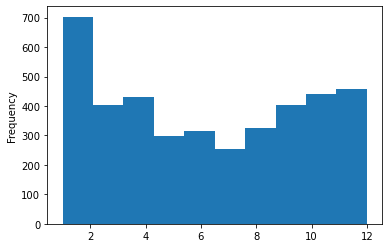

In [26]:
movies['month'].plot(kind='hist')

I could fill in the missing month data by using random months with the same distribution as the data, but I don't think this would add to the analysis, since there are only 33/4064 missing values. I will just drop these rows when I analyze release month vs. ww_gross.

### budget ###

Get all budget data in same format as type float

In [27]:
pd.set_option('display.float_format', lambda x: f'{x: ,.2f}')

In [28]:
movies[movies['budget'].apply(lambda x: type(x))==str].head(50)


,tconst,original_title,start_year,runtime_minutes,genres,budget,ww_gross,mpaa_rating,month
0,tt0249516,Foodfight!,2012,91.00,"['Action', 'Animation', 'Comedy']","{'amount': 65000000.0, 'currency': 'USD'}","120,141.00",PG,2.00
1,tt0326965,In My Sleep,2010,104.00,"['Drama', 'Mystery', 'Thriller']","{'amount': 1000000.0, 'currency': 'USD'}","30,158.00",PG-13,4.00
3,tt0359950,The Secret Life of Walter Mitty,2013,114.00,"['Adventure', 'Comedy', 'Drama']","{'amount': 90000000, 'currency': 'USD'}","188,133,322.00",PG,12.00
4,tt0365907,A Walk Among the Tombstones,2014,114.00,"['Action', 'Crime', 'Drama']","{'amount': 28000000, 'currency': 'USD'}","58,834,384.00",R,9.00
5,tt0369610,Jurassic World,2015,124.00,"['Action', 'Adventure', 'Sci-Fi']","{'amount': 150000000, 'currency': 'USD'}","1,670,516,444.00",PG-13,6.00
6,tt0372538,Spy,2011,110.00,"['Action', 'Crime', 'Drama']","{'amount': 5000000.0, 'currency': 'USD'}","235,600,000.00",Unrated,8.00
7,tt0376136,The Rum Diary,2011,119.00,"['Comedy', 'Drama']","{'amount': 45000000, 'currency': 'USD'}","30,134,958.00",R,10.00
8,tt0383010,The Three Stooges,2012,92.00,"['Comedy', 'Family']","{'amount': 30000000, 'currency': 'USD'}","54,819,301.00",PG,4.00
9,tt0398286,Tangled,2010,100.00,"['Adventure', 'Animation', 'Comedy']","{'amount': 260000000, 'currency': 'USD'}","592,462,816.00",PG,11.00
10,tt0401729,John Carter,2012,132.00,"['Action', 'Adventure', 'Sci-Fi']","{'amount': 250000000, 'currency': 'USD'}","284,139,100.00",PG-13,3.00


In [29]:
def find_dicts(data):
    if type(data)==str:
        if '{' in data:
            return True
        else:
            return False
    else:
        return False

type_bool=movies['budget'].apply(find_dicts)

In [30]:
def fix_budget(x):
    data=eval(x)
    return data['amount']

#type_bool=movies['budget'].apply(lambda x: True if type(x)==str 
 #                                       else False)

movies.loc[type_bool,'budget']=movies.loc[type_bool,'budget'].apply(fix_budget)
movies['budget'].head(10)

0     65,000,000.00
1      1,000,000.00
2               NaN
3     90,000,000.00
4     28,000,000.00
5    150,000,000.00
6      5,000,000.00
7     45,000,000.00
8     30,000,000.00
9    260,000,000.00
Name: budget, dtype: object

In [31]:
movies['budget']=movies['budget'].astype(float)

In [32]:
movies['budget'].describe()

count          2,025.00
mean      32,090,687.79
std       49,186,123.98
min                0.00
25%        2,000,000.00
50%       12,000,000.00
75%       36,000,000.00
max      356,000,000.00
Name: budget, dtype: float64

In [33]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4064 entries, 0 to 4063
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           4064 non-null   object 
 1   original_title   4064 non-null   object 
 2   start_year       4064 non-null   int64  
 3   runtime_minutes  4064 non-null   float64
 4   genres           4062 non-null   object 
 5   budget           2025 non-null   float64
 6   ww_gross         4064 non-null   float64
 7   mpaa_rating      3699 non-null   object 
 8   month            4031 non-null   float64
dtypes: float64(4), int64(1), object(4)
memory usage: 285.9+ KB


In [34]:
movies.to_csv('30SEP_movies.csv',index=False)

In [35]:
movies=pd.read_csv('30SEP_movies.csv')

### Investigate missing data ###
For genres, mpaa_rating, month, verify whether there are movies with missing data that we want included in the analysis. Check what the highest values for ww_gross for the movies missing these values.

In [36]:
#genres
movies[movies['genres'].isnull()].sort_values('ww_gross',ascending=False)

,tconst,original_title,start_year,runtime_minutes,genres,budget,ww_gross,mpaa_rating,month
2105,tt2504610,The Oscar Nominated Short Films 2010: Live Action,2010,97.00,NaN,nan,"1,018,169.00",NaN,3.00
1082,tt1701997,I'm Still Here,2010,60.00,NaN,nan,"569,000.00",NaN,nan


In [37]:
#mpaa_rating
missing_rating=movies[movies['mpaa_rating'].isnull()].sort_values('ww_gross',
                                                   ascending=False)

In [38]:
tmdb_ids=pd.read_csv('tmdb_ids.csv')

In [39]:
missing_mpaa=missing_rating.merge(tmdb_ids,on='tconst')
r_id=missing_mpaa['tmdb_id'].to_list()
r_id[:5]

[473602, 358364, 498716, 523602, 744979]

In [40]:
missing_rating.head()

,tconst,original_title,start_year,runtime_minutes,genres,budget,ww_gross,mpaa_rating,month
1623,tt2071483,Inside Out,2011,59.00,['Family'],"500,000.00","857,600,000.00",NaN,12.00
2847,tt4028068,Wonder Woman,2014,60.00,['Sci-Fi'],"15,000.00","821,900,000.00",NaN,12.00
2526,tt3300078,The Revenant,2012,80.00,['Horror'],"2,000.00","532,900,000.00",NaN,2.00
3456,tt5734820,Rio,2017,87.00,['Drama'],nan,"484,600,000.00",NaN,nan
2185,tt2614250,Rio,2012,90.00,['Documentary'],"250,000.00","484,600,000.00",NaN,nan


In [41]:
movies[movies['original_title'].str.contains('Reven')]

,tconst,original_title,start_year,runtime_minutes,genres,budget,ww_gross,mpaa_rating,month
404,tt1287468,Cats & Dogs: The Revenge of Kitty Galore,2010,82.00,"['Action', 'Comedy', 'Family']","85,000,000.00","112,483,764.00",PG,7.00
467,tt1322362,Revenge of the Mekons,2013,95.00,['Documentary'],"300,000.00","11,861.00",Unrated,11.00
584,tt1413496,Revenge of the Electric Car,2011,90.00,['Documentary'],nan,"151,272.00",PG-13,4.00
1015,tt1663202,The Revenant,2015,156.00,"['Action', 'Adventure', 'Biography']","135,000,000.00","532,950,503.00",R,1.00
2526,tt3300078,The Revenant,2012,80.00,['Horror'],"2,000.00","532,900,000.00",NaN,2.00


In [42]:
movies[movies['original_title'].str.contains('Inside Out')]

,tconst,original_title,start_year,runtime_minutes,genres,budget,ww_gross,mpaa_rating,month
962,tt1640486,Inside Out,2011,93.00,"['Crime', 'Drama']","2,000,000.00","857,600,000.00",PG-13,9.00
1623,tt2071483,Inside Out,2011,59.00,['Family'],"500,000.00","857,600,000.00",NaN,12.00
1666,tt2096673,Inside Out,2015,95.00,"['Adventure', 'Animation', 'Comedy']","175,000,000.00","858,848,019.00",PG,6.00


In [43]:
movies[movies['original_title'].str.contains('Wonder Wom')]

,tconst,original_title,start_year,runtime_minutes,genres,budget,ww_gross,mpaa_rating,month
29,tt0451279,Wonder Woman,2017,141.00,"['Action', 'Adventure', 'Fantasy']","149,000,000.00","822,824,522.00",PG-13,6.00
2847,tt4028068,Wonder Woman,2014,60.00,['Sci-Fi'],"15,000.00","821,900,000.00",NaN,12.00
3581,tt6133130,Professor Marston and the Wonder Women,2017,108.00,"['Biography', 'Drama']",nan,"1,899,615.00",R,10.00


In [44]:
movies[movies['original_title'].str.contains('Rio')]

,tconst,original_title,start_year,runtime_minutes,genres,budget,ww_gross,mpaa_rating,month
612,tt1436562,Rio,2011,96.00,"['Adventure', 'Animation', 'Comedy']","90,000,000.00","483,866,518.00",PG,4.00
1946,tt2357291,Rio 2,2014,101.00,"['Adventure', 'Animation', 'Comedy']","103,000,000.00","498,781,117.00",G,4.00
2185,tt2614250,Rio,2012,90.00,['Documentary'],"250,000.00","484,600,000.00",NaN,nan
3090,tt4642044,Riot,2015,87.00,['Action'],nan,"124,358.00",Unrated,11.00
3456,tt5734820,Rio,2017,87.00,['Drama'],nan,"484,600,000.00",NaN,nan
3728,tt6702308,The Riot Act,2018,101.00,['Thriller'],nan,"75,506.00",PG-13,9.00


It appears that the high-grossing movies without MPAA ratings are actually duplicates with other data errors. It seems like missing ratings could actually be an indicator that the row could have erroneous data.  We will drop rows without MPAA rating.

In [45]:
movies[movies['month'].isnull()].sort_values('ww_gross',
                                             ascending=False).head(10)

,tconst,original_title,start_year,runtime_minutes,genres,budget,ww_gross,mpaa_rating,month
3456,tt5734820,Rio,2017,87.00,['Drama'],nan,"484,600,000.00",NaN,nan
2185,tt2614250,Rio,2012,90.00,['Documentary'],"250,000.00","484,600,000.00",NaN,nan
1683,tt2109176,Noah,2011,105.00,"['Drama', 'Thriller']",nan,"362,599,999.00",NaN,nan
1793,tt2221640,Now You See Me,2012,98.00,"['Drama', 'Horror', 'Thriller']",nan,"351,700,000.00",NaN,nan
3713,tt6598256,No Strings Attached,2017,73.00,"['Comedy', 'Drama', 'Romance']",nan,"149,300,000.00",NaN,nan
2022,tt2402731,Unknown,2012,96.00,['Drama'],nan,"130,799,999.00",NaN,nan
1388,tt1901018,The Visit,2010,50.00,['Thriller'],"1,000.00","98,400,000.00",NaN,nan
3326,tt5324464,Nerve,2015,62.00,"['Documentary', 'History']",nan,"85,300,000.00",NaN,nan
2056,tt2447982,Abduction,2011,84.00,"['Horror', 'Thriller']",nan,"82,100,000.00",NaN,nan
3175,tt4907156,Widows,2015,79.00,['Comedy'],nan,"76,000,000.00",NaN,nan


Missing months also seem to indicate multiple missing values and correspond with the movies missing ratings.  We'll drop all the rows missing any of these three values.

In [46]:
movies=movies[movies['mpaa_rating'].notnull()]
movies=movies[movies['month'].notnull()]
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3696 entries, 0 to 4063
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           3696 non-null   object 
 1   original_title   3696 non-null   object 
 2   start_year       3696 non-null   int64  
 3   runtime_minutes  3696 non-null   float64
 4   genres           3696 non-null   object 
 5   budget           1945 non-null   float64
 6   ww_gross         3696 non-null   float64
 7   mpaa_rating      3696 non-null   object 
 8   month            3696 non-null   float64
dtypes: float64(4), int64(1), object(4)
memory usage: 288.8+ KB


In [47]:
movies.to_csv('30SEP_movies_cleaned.csv',index=False)

In [48]:
#genre_types=master_movies['budget'].map(type)
#genre_types

In [49]:
#ax=sns.regplot(data=master_movies,x='budget',y='ww_gross')
#ax.set_xlim(0,.4e8)

In [50]:
#sns.jointplot(data=master_movies,x='budget',y='ww_gross')

In [51]:
#master_movies['start_year'].value_counts()

## Data Analysis
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

## Genres ##
Look at which genres made the most money, distribution within certain genres? MPAA rating correlation with gross within genres?

In [52]:
#csv saved movies list as a string. turn back into list, then explode
movies_exp=movies.copy()
movies_exp['genres']=movies_exp['genres'].str.strip('[]').str.split(',')
movies_exp=movies_exp.explode('genres')
movies_exp['genres']=movies_exp['genres'].str.strip()
movies_exp.head(10)

,tconst,original_title,start_year,runtime_minutes,genres,budget,ww_gross,mpaa_rating,month
0,tt0249516,Foodfight!,2012,91.00,'Action',"65,000,000.00","120,141.00",PG,2.00
0,tt0249516,Foodfight!,2012,91.00,'Animation',"65,000,000.00","120,141.00",PG,2.00
0,tt0249516,Foodfight!,2012,91.00,'Comedy',"65,000,000.00","120,141.00",PG,2.00
1,tt0326965,In My Sleep,2010,104.00,'Drama',"1,000,000.00","30,158.00",PG-13,4.00
1,tt0326965,In My Sleep,2010,104.00,'Mystery',"1,000,000.00","30,158.00",PG-13,4.00
1,tt0326965,In My Sleep,2010,104.00,'Thriller',"1,000,000.00","30,158.00",PG-13,4.00
2,tt0331314,Bunyan and Babe,2017,84.00,'Adventure',nan,"72,060.00",PG,1.00
2,tt0331314,Bunyan and Babe,2017,84.00,'Animation',nan,"72,060.00",PG,1.00
2,tt0331314,Bunyan and Babe,2017,84.00,'Comedy',nan,"72,060.00",PG,1.00
3,tt0359950,The Secret Life of Walter Mitty,2013,114.00,'Adventure',"90,000,000.00","188,133,322.00",PG,12.00


In [53]:
#groupby genres and calculate mean ww_gross, then sort to get descending order
genre_mean_ww=movies_exp.groupby('genres'
                        ).mean()['ww_gross'].sort_values(ascending=False)
g_mean_order=genre_mean_ww.index

In [54]:
#groupby genres and calculate med ww_gross, then sort to get descending order
genre_med_ww=movies_exp.groupby('genres'
                        ).median()['ww_gross'].sort_values(ascending=False)
g_med_order=genre_med_ww.index

<AxesSubplot:xlabel='ww_gross', ylabel='genres'>

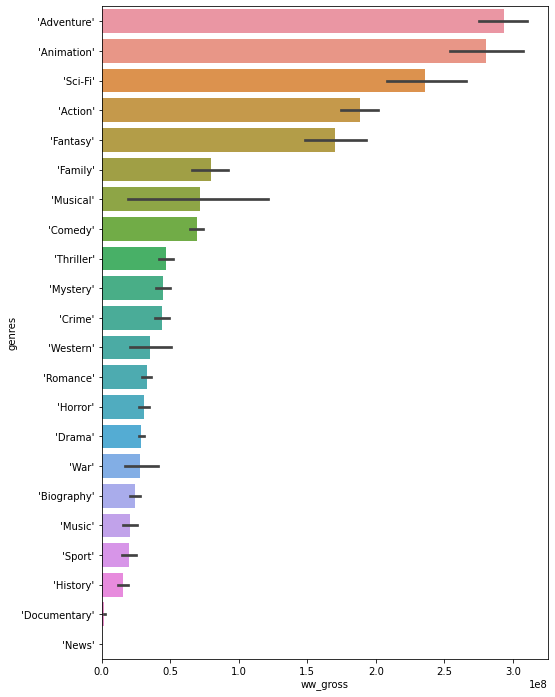

In [55]:
#plot the mean worldwide gross for each genre
plt.figure(figsize=(8,12))
sns.barplot(data=movies_exp,x='ww_gross',y='genres',ci=68,order=g_mean_order)

<AxesSubplot:xlabel='ww_gross', ylabel='genres'>

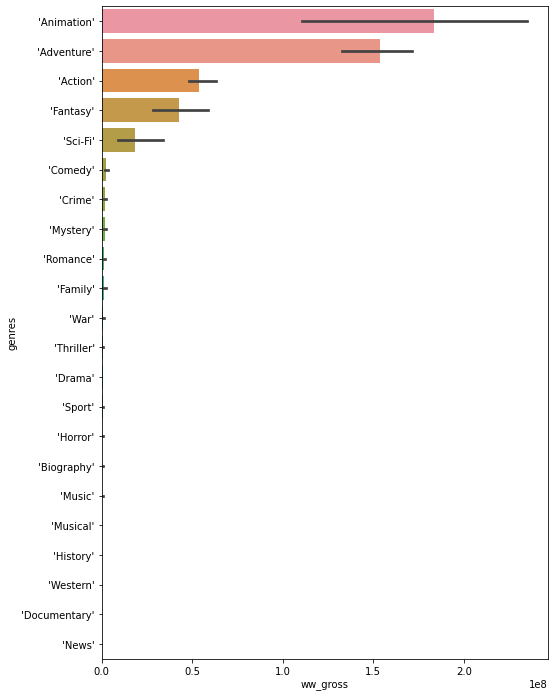

In [56]:
#plot the mean worldwide gross for each genre
plt.figure(figsize=(8,12))
sns.barplot(data=movies_exp,x='ww_gross',y='genres',
            ci=68,order=g_med_order,estimator=np.median)

In [57]:
#add columns to show mean and median of the genre
mean_df=genre_mean_ww.to_frame()
movies_exp=movies_exp.merge(mean_df,on='genres')

med_df=genre_med_ww.to_frame()
movies_exp=movies_exp.merge(med_df,on='genres')
movies_exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8211 entries, 0 to 8210
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           8211 non-null   object 
 1   original_title   8211 non-null   object 
 2   start_year       8211 non-null   int64  
 3   runtime_minutes  8211 non-null   float64
 4   genres           8211 non-null   object 
 5   budget           4710 non-null   float64
 6   ww_gross_x       8211 non-null   float64
 7   mpaa_rating      8211 non-null   object 
 8   month            8211 non-null   float64
 9   ww_gross_y       8211 non-null   float64
 10  ww_gross         8211 non-null   float64
dtypes: float64(6), int64(1), object(4)
memory usage: 769.8+ KB


In [58]:
movies_exp=movies_exp.rename(columns={'ww_gross_y':'mean',
                                      'ww_gross_x':'ww_gross',
                                      'ww_gross':'median'})
movies_exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8211 entries, 0 to 8210
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           8211 non-null   object 
 1   original_title   8211 non-null   object 
 2   start_year       8211 non-null   int64  
 3   runtime_minutes  8211 non-null   float64
 4   genres           8211 non-null   object 
 5   budget           4710 non-null   float64
 6   ww_gross         8211 non-null   float64
 7   mpaa_rating      8211 non-null   object 
 8   month            8211 non-null   float64
 9   mean             8211 non-null   float64
 10  median           8211 non-null   float64
dtypes: float64(6), int64(1), object(4)
memory usage: 769.8+ KB


In [59]:
movies_exp['genres']=movies_exp['genres'].str.strip("''")
movies_exp.loc[0,'genres']

'Action'

<AxesSubplot:ylabel='Frequency'>

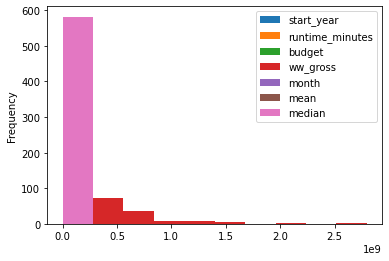

In [60]:
action=movies_exp[movies_exp['genres']=='Action']
action.plot.hist()

In [61]:
plot_df=movies_exp[(movies_exp['genres']=='Action') | 
                  (movies_exp['genres']=='Animation') | 
                  (movies_exp['genres']=='Adventure') | 
                  (movies_exp['genres']=='Fantasy') |
                  (movies_exp['genres']=='Sci-Fi')]
plot_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1526 entries, 0 to 7111
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           1526 non-null   object 
 1   original_title   1526 non-null   object 
 2   start_year       1526 non-null   int64  
 3   runtime_minutes  1526 non-null   float64
 4   genres           1526 non-null   object 
 5   budget           1239 non-null   float64
 6   ww_gross         1526 non-null   float64
 7   mpaa_rating      1526 non-null   object 
 8   month            1526 non-null   float64
 9   mean             1526 non-null   float64
 10  median           1526 non-null   float64
dtypes: float64(6), int64(1), object(4)
memory usage: 143.1+ KB


In [62]:
#define a dictionary with genres for labeling plot
genre_dict={1:'Action',2:'Animation',3:'Adventure',4:'Sci-Fi',5:'Fantasy'}

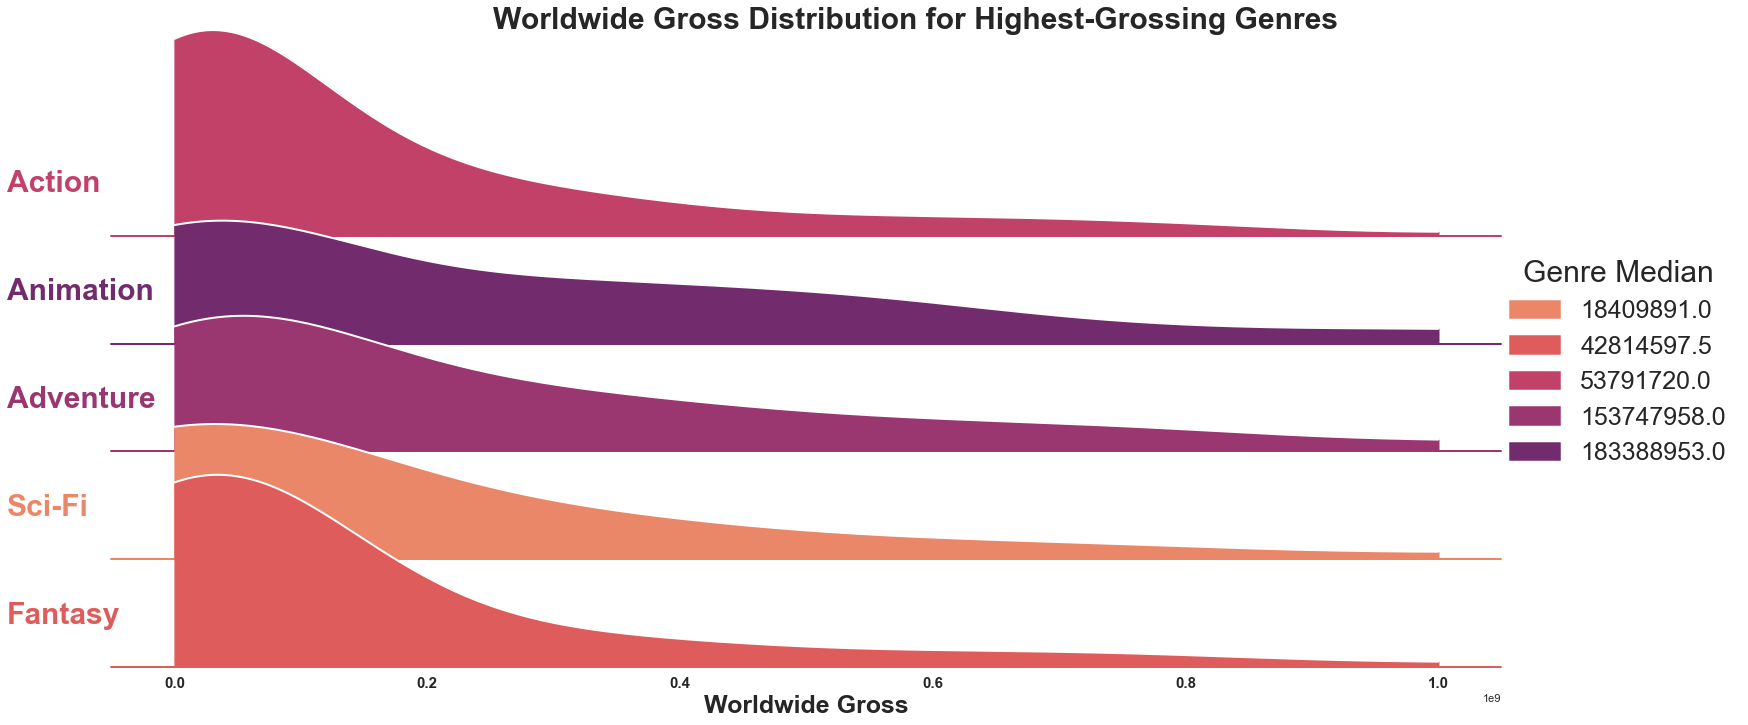

In [63]:
#create a ridgeline plot to show distributions of each genre
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.color_palette(palette='flare', n_colors=5)

g=sns.FacetGrid(plot_df, row='genres', hue='median',aspect=10,height=2,
               palette=pal)

#g.map(sns.histplot, 'ww_gross',bins=5,binrange=(0,1000000000))
#add the densities kdeplots for each genre
g.map(sns.kdeplot, 'ww_gross', bw_adjust=1, clip=(0,1000000000), fill=True, alpha=1,
     linewidth=1.5)

# here we add a white line that represents the contour of each kdeplot
g.map(sns.kdeplot, 'ww_gross', 
      bw_adjust=1, clip=(0,1000000000), 
      color="w", lw=2)

# here we add a horizontal line for each plot
g.map(plt.axhline, y=0,
      lw=2, clip_on=False)

# we loop over the FacetGrid figure axes (g.axes.flat) and add the month as text with the right color
for i, ax in enumerate(g.axes.flat):
    ax.text(-.075, 0.2, genre_dict[i+1],
            fontweight='bold', fontsize=30, transform=ax.transAxes,
            color=ax.lines[-1].get_color())
#def annotate(data, **kws):
 #   genre='genres'
  #  ax=plt.gca()
   # ax.text(-.05,.05,genre,transform=ax.transAxes,
    #        color=ax.lines[-1].get_color(),fontweight='bold',fontsize=18)
    
#g.map_dataframe(annotate)
    
# we use matplotlib.Figure.subplots_adjust() function to get the subplots to overlap
g.fig.subplots_adjust(hspace=-0.5)

# eventually we remove axes titles, yticks and spines
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

plt.setp(ax.get_xticklabels(), fontsize=15, fontweight='bold')
plt.xlabel('Worldwide Gross', fontweight='bold', fontsize=25)
g.fig.suptitle('Worldwide Gross Distribution for Highest-Grossing Genres',
               ha='center',
               fontsize=30,
               fontweight='bold')

g.add_legend(fontsize=25)
g._legend.set_title('Genre Median',prop={'size':30})

Mean of Adventure is higher, but Animation has more films with higher gross. Sci-Fi does not rank as high but looks like has higher chance of success than Fantasy or Action.  (Fix this)

<AxesSubplot:xlabel='genres', ylabel='ww_gross'>

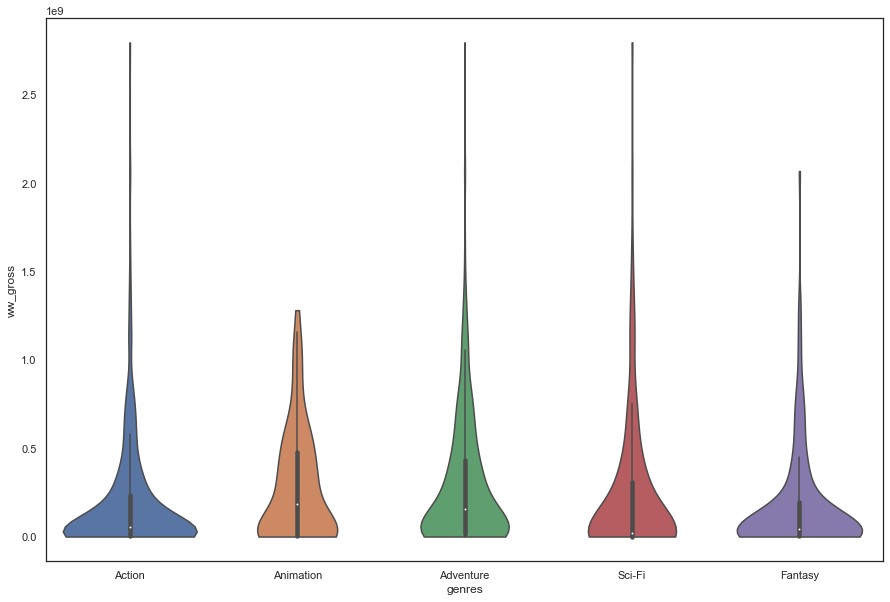

In [64]:
#Try a violin plot
fig, ax = plt.subplots(figsize=(15,10))
sns.violinplot(data=plot_df,x='genres',y='ww_gross',ax=ax, cut=0)


<AxesSubplot:xlabel='genres', ylabel='ww_gross'>

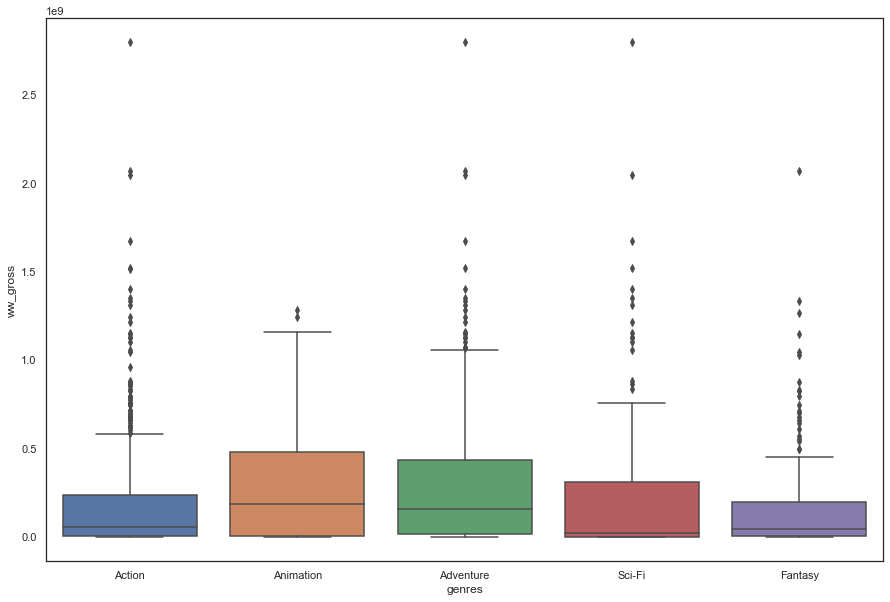

In [65]:
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(data=plot_df,x='genres',y='ww_gross',ax=ax)

In [66]:
adventure=movies_exp[movies_exp['genres']=='Adventure']
adventure['ww_gross'].describe()

count              428.00
mean       293,082,502.99
std        372,156,970.19
min              1,777.00
25%         12,535,844.50
50%        153,747,958.00
75%        431,018,794.75
max      2,797,501,328.00
Name: ww_gross, dtype: float64

## MPAA Rating ##
Worldwide gross by rating group, in the highest-grossing genres movies with which content level do best?

In [67]:
#groupby mpaa rating and calculate mean ww_gross, then sort to get descending order
mpaa_mean_ww=movies.groupby('mpaa_rating'
                        ).mean()['ww_gross'].sort_values(ascending=False)
mpaa_mean_order=mpaa_mean_ww.index

In [68]:
#groupby mpaa rating and calculate med ww_gross, then sort to get descending order
mpaa_med_ww=movies.groupby('mpaa_rating'
                        ).median()['ww_gross'].sort_values(ascending=False)
mpaa_med_order=mpaa_med_ww.index

<AxesSubplot:xlabel='ww_gross', ylabel='mpaa_rating'>

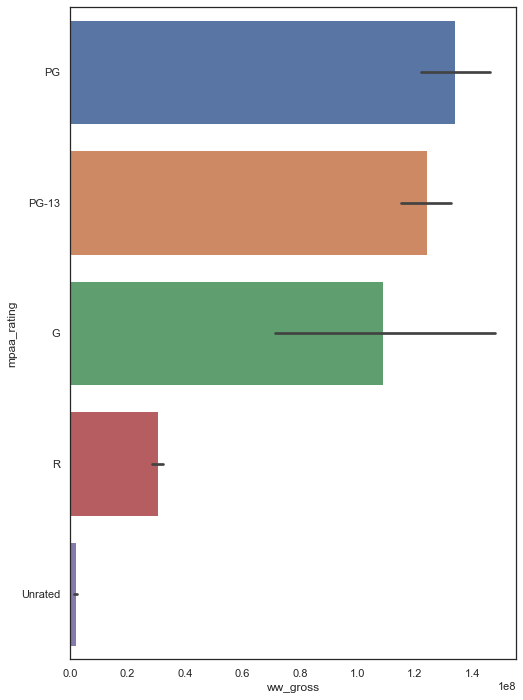

In [69]:
#plot the mean worldwide gross for each mpaa
plt.figure(figsize=(8,12))
sns.barplot(data=movies,x='ww_gross',y='mpaa_rating',ci=68,
            order=mpaa_mean_order)

<AxesSubplot:xlabel='ww_gross', ylabel='mpaa_rating'>

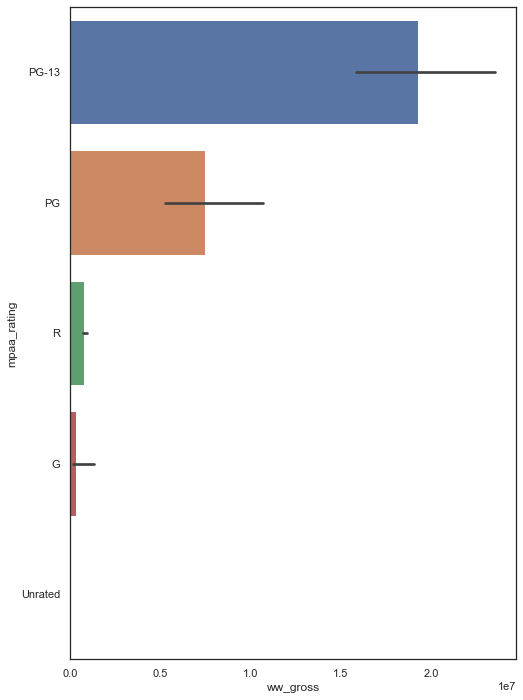

In [70]:
#plot the med worldwide gross for each mpaa rating
plt.figure(figsize=(8,12))
sns.barplot(data=movies,x='ww_gross',y='mpaa_rating',ci=68,
            order=mpaa_med_order,estimator=np.median)

There is a big difference between the median and means of the movies grouped by MPAA rating. PG-13 has the highest median, while PG has the highest mean. The data appears to have a right skew, given that the means are an order of magnitude higher for most groups due to high-grossing outliers.

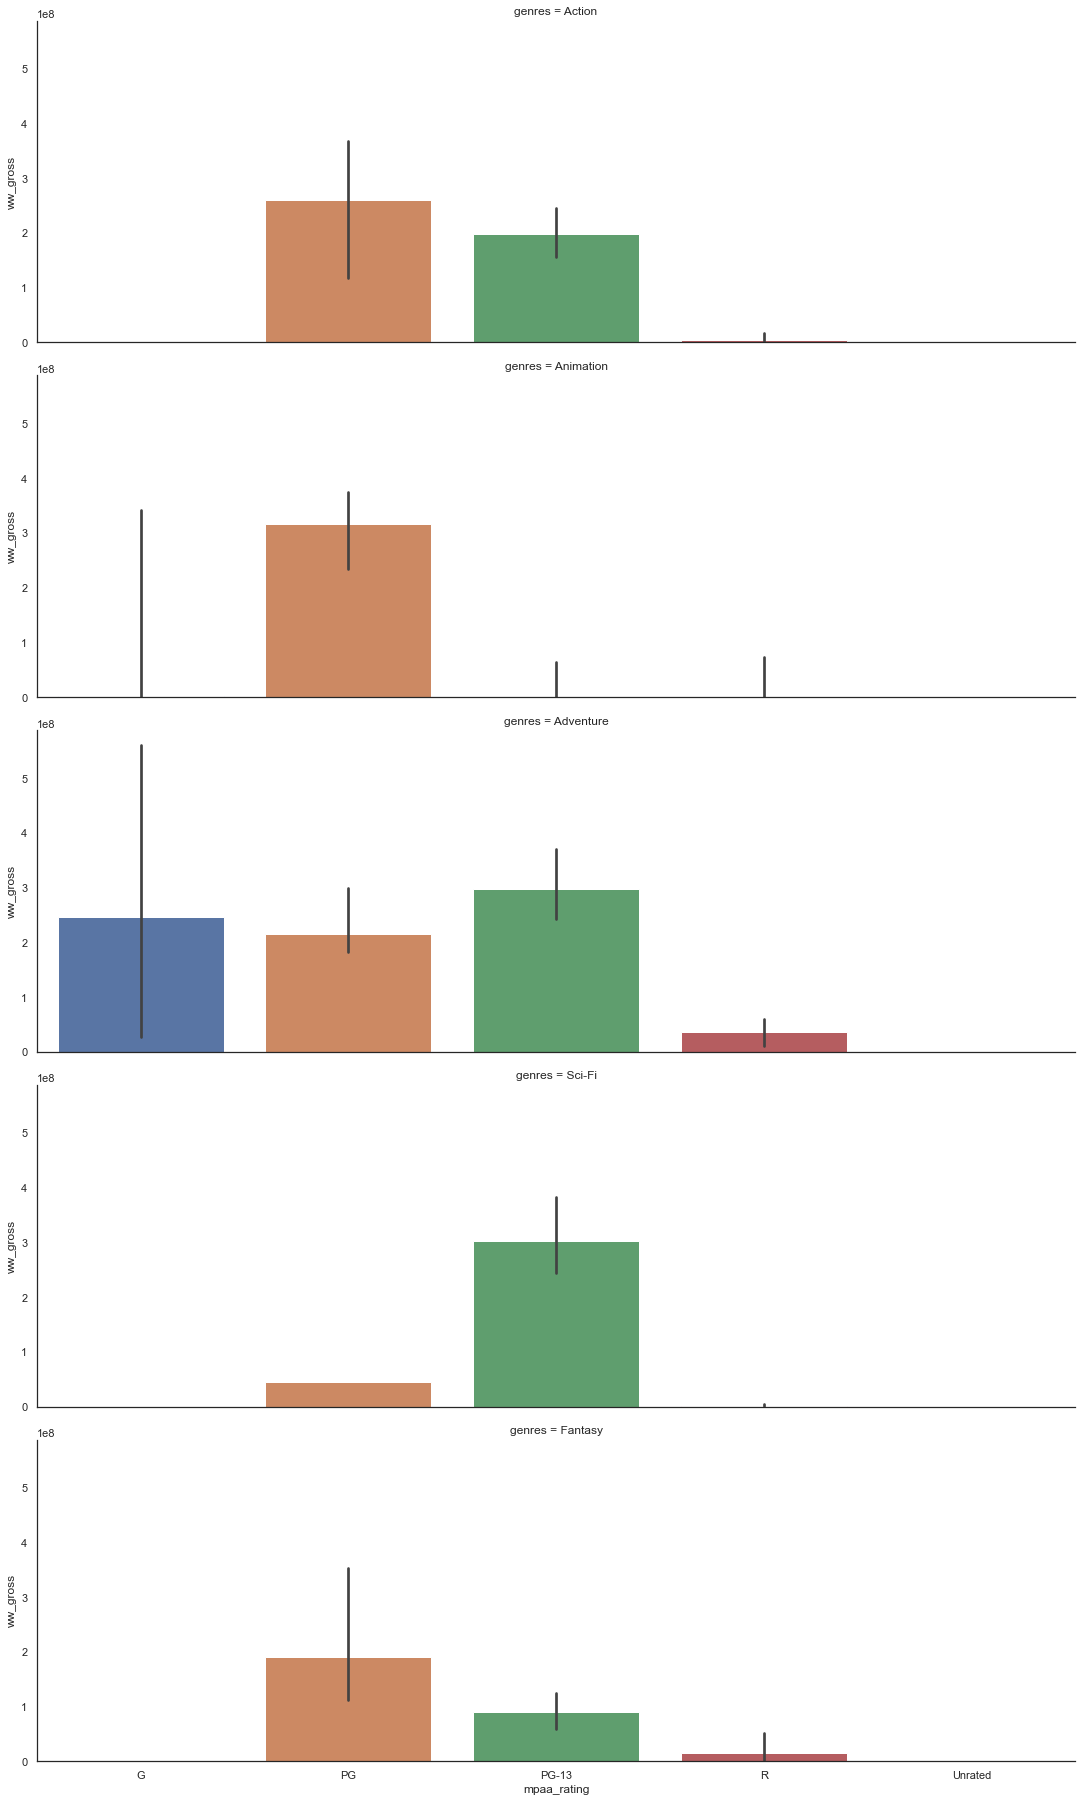

In [71]:
#Examine median ww_gross of each mpaa rating within genres

g=sns.catplot(kind='bar', row='genres', x='mpaa_rating',y='ww_gross', 
              data=plot_df, estimator=np.median, aspect=3,
              order=['G','PG','PG-13','R','Unrated'])

## Release Month ##
Movies released in which month have the highest mean/median worldwide gross? Does this vary by genre among the highest grossing genres?

[Text(0, 0.0, '$0'),
 Text(0, 20000000.0, '$20,000,000'),
 Text(0, 40000000.0, '$40,000,000'),
 Text(0, 60000000.0, '$60,000,000'),
 Text(0, 80000000.0, '$80,000,000'),
 Text(0, 100000000.0, '$100,000,000'),
 Text(0, 120000000.0, '$120,000,000'),
 Text(0, 140000000.0, '$140,000,000')]

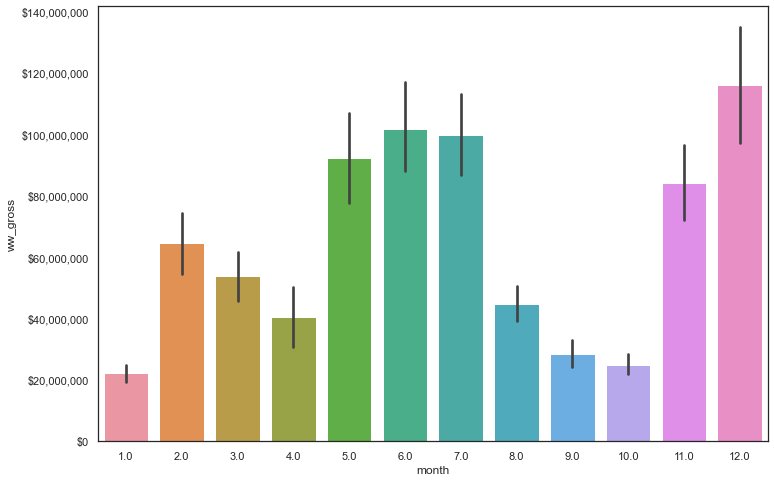

In [72]:
#plot the mean worldwide gross for each mpaa
plt.figure(figsize=(12,8))
m_month=sns.barplot(data=movies,x='month',y='ww_gross',ci=68)
ticks=m_month.get_yticks().tolist()
m_month.yaxis.set_ticks(ticks[:-1])
ylabels=['$'+'{:,.0f}'.format(y) for y in ticks[:-1]]
m_month.set_yticklabels(ylabels)

[Text(0, 0.0, '$0'),
 Text(0, 2500000.0, '$2,500,000'),
 Text(0, 5000000.0, '$5,000,000'),
 Text(0, 7500000.0, '$7,500,000'),
 Text(0, 10000000.0, '$10,000,000'),
 Text(0, 12500000.0, '$12,500,000'),
 Text(0, 15000000.0, '$15,000,000'),
 Text(0, 17500000.0, '$17,500,000')]

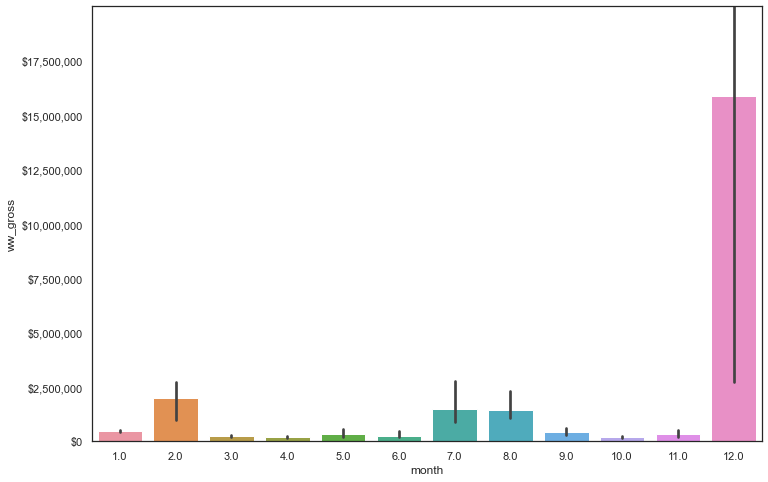

In [73]:
#plot the median worldwide gross for each mpaa
plt.figure(figsize=(12,8))
med_month=sns.barplot(data=movies,x='month',y='ww_gross',ci=68,estimator=np.median)
plt.ylim(0,20000000)
ticks=med_month.get_yticks().tolist()
med_month.yaxis.set_ticks(ticks[:-1])
ylabels=['$'+'{:,.0f}'.format(y) for y in ticks[:-1]]
med_month.set_yticklabels(ylabels)

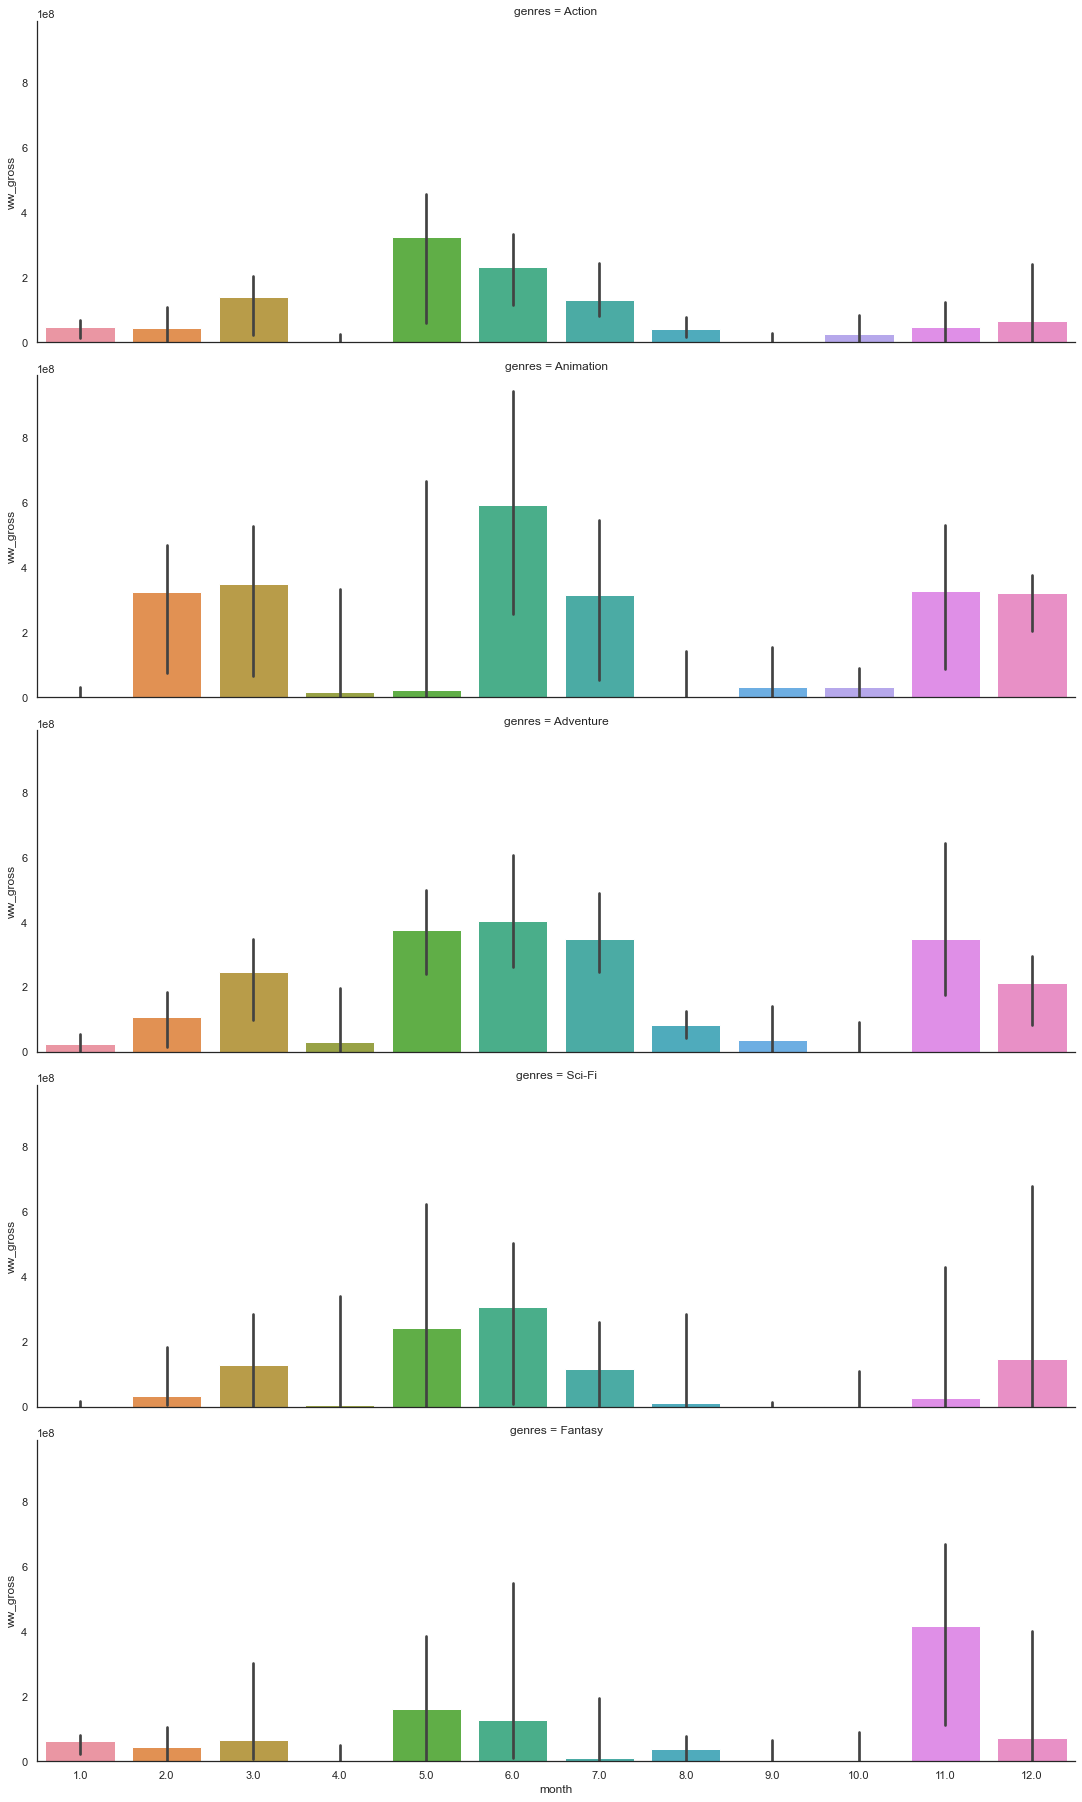

In [74]:
#For 5 highest-grossing genres, look at median worldwide gross across months

month_genre=sns.catplot(kind='bar', row='genres', x='month',y='ww_gross', 
              data=plot_df, estimator=np.median, aspect=3)

When you look at worldwide gross distribution by genre, they differ from the distribution that includes all movies.  There are still peaks in summer and holiday season months, but for some genres, summer months have higher median worldwide gross.

mpaa_rating
PG         131,523,093.00
PG-13       68,295,545.09
R           32,360,446.16
Unrated      1,612,908.81
Name: ww_gross, dtype: float64

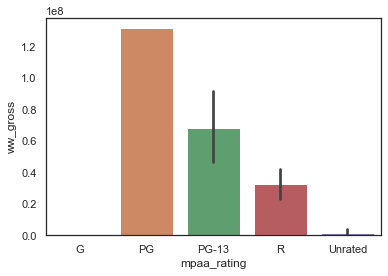

In [75]:
horror=movies_exp[movies_exp['genres']=='Horror']
sns.barplot(data=horror,x='mpaa_rating',y='ww_gross',
              order=['G','PG','PG-13','R','Unrated'])
horror.groupby('mpaa_rating'
                        ).mean()['ww_gross'].sort_values(ascending=False)

month
1.00     45,644,577.09
7.00     44,009,152.81
8.00     41,575,490.46
6.00     35,919,342.54
9.00     35,619,320.16
10.00    31,337,351.91
4.00     30,656,910.35
5.00     26,458,641.07
2.00     24,575,426.54
3.00     14,066,981.72
12.00    10,301,663.53
11.00     6,109,343.89
Name: ww_gross, dtype: float64

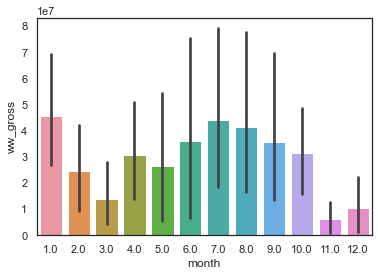

In [76]:
sns.barplot(data=horror,x='month',y='ww_gross')
horror.groupby('month'
                        ).mean()['ww_gross'].sort_values(ascending=False)

## Genre, MPAA Rating, and Month ##
Examine the highest grossing combinations of these three variables.

In [77]:
#groupby genres, mpaa rating, and month and calculate mean ww_gross
mean_3=movies_exp.groupby(['genres','mpaa_rating',
                    'month']).mean()['ww_gross'].sort_values(ascending=False)

In [78]:
#groupby genres, mpaa rating, and month and calculate mean ww_gross
med_3=movies_exp.groupby(['genres','mpaa_rating',
                    'month']).median()['ww_gross'].sort_values(ascending=False)

In [79]:
#groupby genres, mpaa rating, and month and calculate mean ww_gross and count movies in category
all_3_mean=movies_exp.groupby(['genres','mpaa_rating',
                    'month']).agg({'ww_gross': ['count',
                    'mean']}).sort_values(('ww_gross','mean'),ascending=False)
all_3_mean.head(10)

ww_gross                
                               count            mean
genres    mpaa_rating month                         
Fantasy   PG-13       12.00        5  939,224,988.20
Sci-Fi    PG-13       5.00        12  767,510,057.50
Animation PG          6.00         9  736,642,177.00
Adventure PG          6.00         9  727,591,018.56
Sci-Fi    PG-13       4.00        10  677,116,707.80
Adventure PG-13       5.00        23  661,704,931.83
Comedy    G           6.00         6  638,170,340.17
Action    PG-13       12.00       15  596,501,532.93
Sci-Fi    PG-13       6.00        14  594,844,174.14
Action    PG          6.00         4  587,682,687.25

In [80]:
#groupby genres, mpaa rating, and month and calculate median ww_gross and count movies in category
all_3_med=movies_exp.groupby(['genres','mpaa_rating',
                    'month']).agg({'ww_gross': ['count',
                    'median']}).sort_values(('ww_gross','median'),ascending=False)
all_3_med.head(20)

ww_gross                  
                               count            median
genres    mpaa_rating month                           
Fantasy   PG-13       12.00        5  1,148,485,886.00
Adventure PG          6.00         9    746,921,274.00
Animation PG          6.00         9    746,921,274.00
Adventure PG-13       11.00       12    668,070,106.50
Sci-Fi    PG-13       5.00        12    666,457,827.00
Fantasy   PG-13       11.00        7    657,926,987.00
Comedy    G           6.00         6    651,706,020.50
Adventure G           6.00         7    559,852,396.00
Fantasy   PG-13       6.00         4    553,861,477.00
Action    PG          5.00         4    549,806,790.50
Adventure PG-13       5.00        23    543,934,105.00
Action    PG-13       5.00        28    499,483,450.50
Animation G           4.00         1    498,781,117.00
Action    PG          3.00         3    494,879,471.00
Fantasy   PG          3.00         7    493,311,825.00
Action    PG          6.00         4    490,331,770.50
Animation G           6.00         8    471,891,526.00
          PG          7.00        14    468,669,374.50
                      5.00         4    467,059,457.50
Adventure PG-13       7.00        19    440,603,537.00

In [81]:
movies_exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8211 entries, 0 to 8210
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           8211 non-null   object 
 1   original_title   8211 non-null   object 
 2   start_year       8211 non-null   int64  
 3   runtime_minutes  8211 non-null   float64
 4   genres           8211 non-null   object 
 5   budget           4710 non-null   float64
 6   ww_gross         8211 non-null   float64
 7   mpaa_rating      8211 non-null   object 
 8   month            8211 non-null   float64
 9   mean             8211 non-null   float64
 10  median           8211 non-null   float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.1+ MB


In [82]:
#multiple linear regression. separate dependent (y) and independent (x) variables
x=movies_exp.copy()
x=x[['genres','mpaa_rating','month']]
x['month']=x['month'].astype(str)
y=movies_exp.copy()
y=y['ww_gross']

In [83]:
#create dummy variables for all three independent variables since they are categorical
x=pd.get_dummies(x)


In [86]:
# importing train_test_split from sklearn
from sklearn.model_selection import train_test_split
# splitting the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 89)

In [87]:
# importing module
from sklearn.linear_model import LinearRegression
# creating an object of LinearRegression class
LR = LinearRegression()
# fitting the training data
LR.fit(x_train,y_train)

LinearRegression()

In [88]:
y_prediction =  LR.predict(x_test)
y_prediction

array([9.12261120e+07, 1.77209344e+08, 6.71088640e+07, ...,
       2.68959744e+08, 7.34003200e+07, 9.33232640e+07])

In [89]:
LR.coef_

array([ 1.36234016e+21,  1.36234016e+21,  1.36234016e+21,  1.36234016e+21,
        1.36234016e+21,  1.36234016e+21,  1.36234016e+21,  1.36234016e+21,
        1.36234016e+21,  1.36234016e+21,  1.36234016e+21,  1.36234016e+21,
        1.36234016e+21,  1.36234016e+21,  1.36234016e+21,  1.36234016e+21,
        1.36234016e+21,  1.36234016e+21,  1.36234016e+21,  1.36234016e+21,
        1.36234016e+21,  1.36234016e+21, -9.53813628e+20, -9.53813628e+20,
       -9.53813628e+20, -9.53813628e+20, -9.53813628e+20, -3.14969288e+21,
       -3.14969288e+21, -3.14969288e+21, -3.14969288e+21, -3.14969288e+21,
       -3.14969288e+21, -3.14969288e+21, -3.14969288e+21, -3.14969288e+21,
       -3.14969288e+21, -3.14969288e+21, -3.14969288e+21])

In [90]:
# importing r2_score module
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# predicting the accuracy score
score=r2_score(y_test,y_prediction)
print('r2 score is ',score)
print('mean_sqrd_error is==',mean_squared_error(y_test,y_prediction))
print('root_mean_squared error of is==',np.sqrt(mean_squared_error(y_test,
                                                            y_prediction)))

r2 score is  0.21264176295141213
mean_sqrd_error is== 3.673508291532772e+16
root_mean_squared error of is== 191663984.39802852


## ROI vs. Genre/Rating/Month ##

Use a subset of the original data set that has reported budgets.  Evaluate the differences in the datasets.  Decide whether to filter the budgets.  Create ROI column.  Do same analysis based on ROI.

In [91]:
#pull out movies with non-null budget
roi_df=movies.copy()
roi_df=roi_df[roi_df['budget'].notnull()]
roi_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1945 entries, 0 to 4053
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           1945 non-null   object 
 1   original_title   1945 non-null   object 
 2   start_year       1945 non-null   int64  
 3   runtime_minutes  1945 non-null   float64
 4   genres           1945 non-null   object 
 5   budget           1945 non-null   float64
 6   ww_gross         1945 non-null   float64
 7   mpaa_rating      1945 non-null   object 
 8   month            1945 non-null   float64
dtypes: float64(4), int64(1), object(4)
memory usage: 152.0+ KB


[Text(-50000000.0, 0, '$-50,000,000'),
 Text(0.0, 0, '$0'),
 Text(50000000.0, 0, '$50,000,000'),
 Text(100000000.0, 0, '$100,000,000'),
 Text(150000000.0, 0, '$150,000,000'),
 Text(200000000.0, 0, '$200,000,000'),
 Text(250000000.0, 0, '$250,000,000'),
 Text(300000000.0, 0, '$300,000,000'),
 Text(350000000.0, 0, '$350,000,000')]

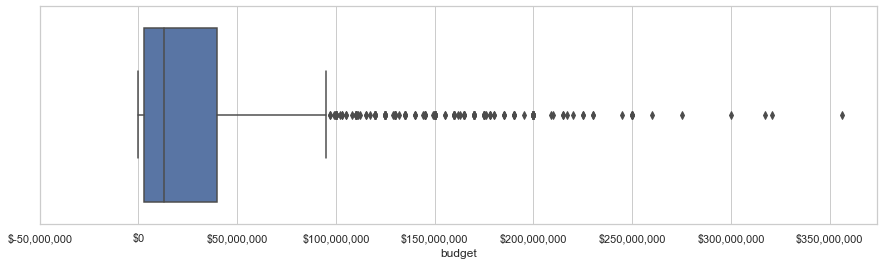

In [92]:
#examine distribution of budgets
plt.figure(figsize=(15,4))
sns.set_style('whitegrid')
b=sns.boxplot(data=roi_df,x='budget')
ticks=b.get_xticks().tolist()
b.xaxis.set_ticks(ticks[:-1])
xlabels=['$'+'{:,.0f}'.format(x) for x in ticks[:-1]]
b.set_xticklabels(xlabels)

In [93]:
roi_df['budget'].describe()

count          1,945.00
mean      33,378,318.68
std       49,766,651.08
min                0.00
25%        3,000,000.00
50%       13,000,000.00
75%       40,000,000.00
max      356,000,000.00
Name: budget, dtype: float64

For the ROI analysis, I want to remove very low-budget films since they are made and marketed very differently from studio productions like the ones Microsoft would be interested in making. I also want to keep any extremely low budget films that did well from inflating the numbers since their ROI would be extreme. However, I also need to be careful not to lose too much data. There will still be independent films, but it should be a better representation.

For this analysis, I'll take everything at or above the lower quartile of $3,000,000.

In [94]:
#filter for budgets greater than or equal to 3 million USD

roi_df=roi_df[roi_df['budget']>=3000000]
roi_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1471 entries, 0 to 4018
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           1471 non-null   object 
 1   original_title   1471 non-null   object 
 2   start_year       1471 non-null   int64  
 3   runtime_minutes  1471 non-null   float64
 4   genres           1471 non-null   object 
 5   budget           1471 non-null   float64
 6   ww_gross         1471 non-null   float64
 7   mpaa_rating      1471 non-null   object 
 8   month            1471 non-null   float64
dtypes: float64(4), int64(1), object(4)
memory usage: 114.9+ KB


### Compare ROI dataset with overall Movies dataset ###

In [95]:
roi_df['genres'].head()

0    ['Action', 'Animation', 'Comedy']
3     ['Adventure', 'Comedy', 'Drama']
4         ['Action', 'Crime', 'Drama']
5    ['Action', 'Adventure', 'Sci-Fi']
6         ['Action', 'Crime', 'Drama']
Name: genres, dtype: object

In [96]:
#need to fix genres column and then flip the plots vertically and do side by side

roi_df['genres']=roi_df['genres'].str.strip('[]').str.split(',')
roi_df_exp=roi_df.explode('genres')


In [97]:
roi_df_exp['genres']=roi_df_exp['genres'].str.strip()
roi_df_exp['genres'].value_counts()

'Drama'          701
'Comedy'         540
'Action'         459
'Adventure'      341
'Thriller'       263
'Crime'          259
'Romance'        192
'Horror'         173
'Sci-Fi'         122
'Mystery'        121
'Fantasy'        119
'Biography'      118
'Animation'      103
'Family'          81
'Music'           53
'History'         37
'Sport'           30
'Documentary'     17
'War'             16
'Western'         15
'Musical'          6
Name: genres, dtype: int64

In [98]:
g_count=movies_exp.groupby('genres'
                          ).count()['ww_gross'].sort_values(ascending=False)
g_count=(g_count/g_count.sum())*100
g_count=g_count.reset_index()

In [99]:
g_count=g_count.rename(columns={'ww_gross':'percent'})
g_count.head()

,genres,percent
0,Drama,20.78
1,Comedy,13.12
2,Documentary,8.73
3,Action,7.09
4,Thriller,6.92


In [100]:
rg_count=roi_df_exp.groupby('genres'
                          ).count()['ww_gross'].sort_values(ascending=False)
rg_count=(rg_count/rg_count.sum())*100
rg_count=rg_count.reset_index()

In [101]:
rg_count=rg_count.rename(columns={'ww_gross':'percent'})
rg_count.head()

,genres,percent
0,'Drama',18.61
1,'Comedy',14.34
2,'Action',12.19
3,'Adventure',9.05
4,'Thriller',6.98


Text(0.5, 1.0, 'Movies for ROI Analysis')

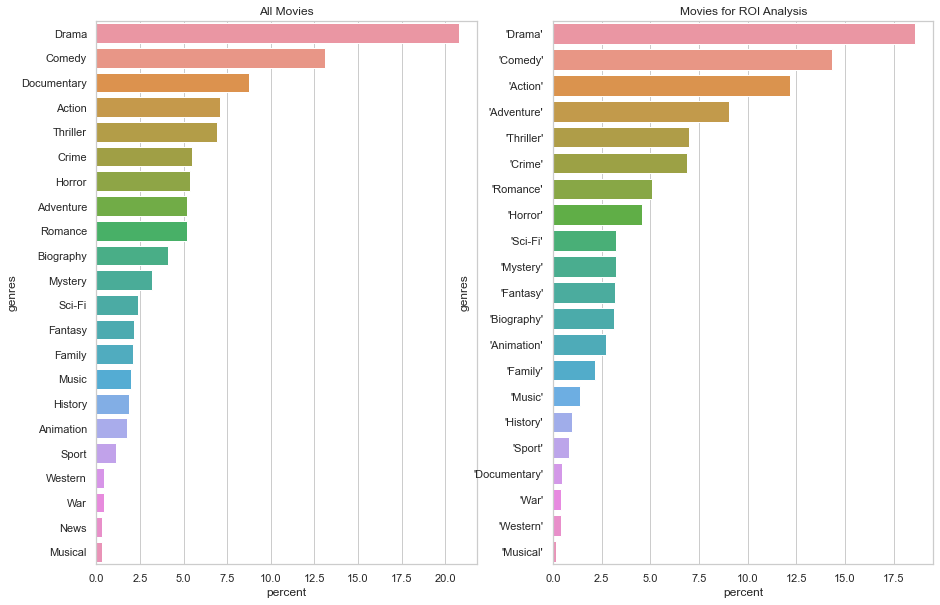

In [102]:
#compare genre breakdown

fig, axs=plt.subplots(1,2,figsize=(15,10))
sns.barplot(data=g_count,y='genres',x='percent',ax=axs[0])
axs[0].set_title('All Movies')
sns.barplot(data=rg_count,y='genres',x='percent',ax=axs[1])
axs[1].set_title('Movies for ROI Analysis')

The genre distribution of both datasets is similar. Some big differences are documentaries make up over 8% of the entire dataset but only 1% of the ROI dataset.  There is a higher percentage of Animation, one of the highest grossing genres, in the ROI dataset (2.0% vs over 2.5%), and Adventure makes up 5% of the overall dataset but over 8% of the ROI dataset.

In [103]:
#compare mpaa rating distribution
#count from overall dataset
mp_count=movies_exp.groupby('mpaa_rating'
                          ).count()['ww_gross'].sort_values(ascending=False)
mp_count=(mp_count/mp_count.sum())*100
mp_count=mp_count.reset_index()
mp_count=mp_count.rename(columns={'ww_gross':'percent'})
print(mp_count.head())

mpr_count=roi_df_exp.groupby('mpaa_rating'
                          ).count()['ww_gross'].sort_values(ascending=False)
mpr_count=(mpr_count/mpr_count.sum())*100
mpr_count=mpr_count.reset_index()
mpr_count=mpr_count.rename(columns={'ww_gross':'percent'})
mpr_count.head()

  mpaa_rating  percent
0           R    39.34
1       PG-13    26.05
2     Unrated    22.56
3          PG    10.83
4           G     1.23


,mpaa_rating,percent
0,R,42.86
1,PG-13,38.90
2,PG,14.45
3,Unrated,2.63
4,G,1.17


Text(0.5, 1.0, 'Movies for ROI Analysis')

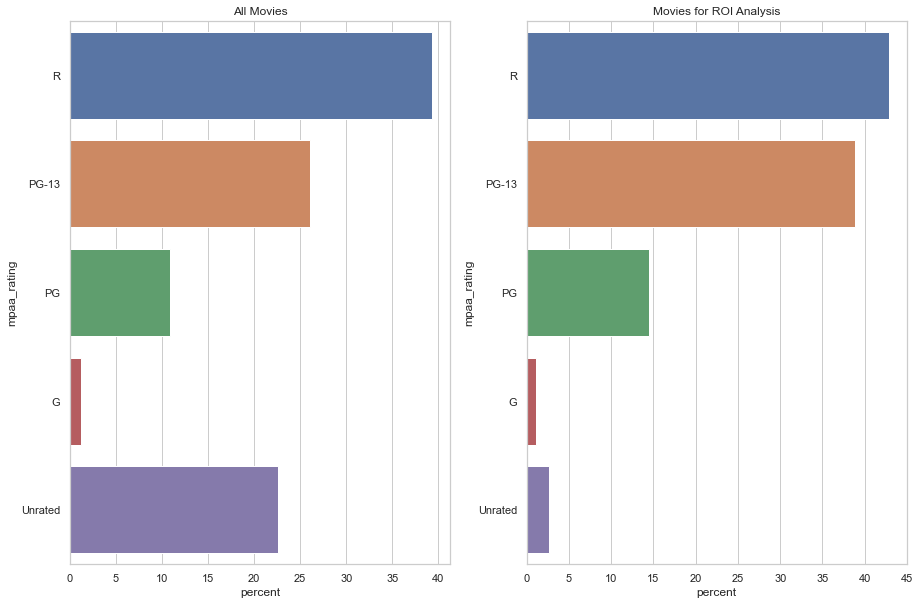

In [104]:
#compare mpaa rating breakdown
mpaa_ord=['R','PG-13','PG','G','Unrated']

fig, axs=plt.subplots(1,2,figsize=(15,10))
sns.barplot(data=mp_count,y='mpaa_rating',x='percent',ax=axs[0],
            order=mpaa_ord)
axs[0].set_title('All Movies')
sns.barplot(data=mpr_count,y='mpaa_rating',x='percent',ax=axs[1],
            order=mpaa_ord)
axs[1].set_title('Movies for ROI Analysis')

The ROI dataset has far fewer Unrated films, probably because extremely low budget films were filtered out.  There is a much smaller difference in percentage of R and PG-13 films making up the dataset in the ROI group.

In [105]:
#Compare distribution of release month between the two datasets

#count from overall dataset
m_count=movies_exp.groupby('month'
                          ).count()['ww_gross']
m_count=(m_count/m_count.sum())*100
m_count=m_count.reset_index()
m_count=m_count.rename(columns={'ww_gross':'percent'})
m_count=m_count.sort_values('month')
m_count['month']=m_count['month'].astype(str)
print(m_count.head())

mr_count=roi_df_exp.groupby('month'
                          ).count()['ww_gross']
mr_count=(mr_count/mr_count.sum())*100
mr_count=mr_count.reset_index()
mr_count=mr_count.rename(columns={'ww_gross':'percent'})
mr_count=mr_count.sort_values('month')
mr_count['month']=mr_count['month'].astype(str)
mr_count.head()

  month  percent
0   1.0    11.57
1   2.0     5.86
2   3.0    10.05
3   4.0    10.47
4   5.0     7.22


,month,percent
0,1.0,9.24
1,2.0,7.46
2,3.0,9.53
3,4.0,8.28
4,5.0,7.43


Text(0.5, 1.0, 'Movies for ROI Analysis')

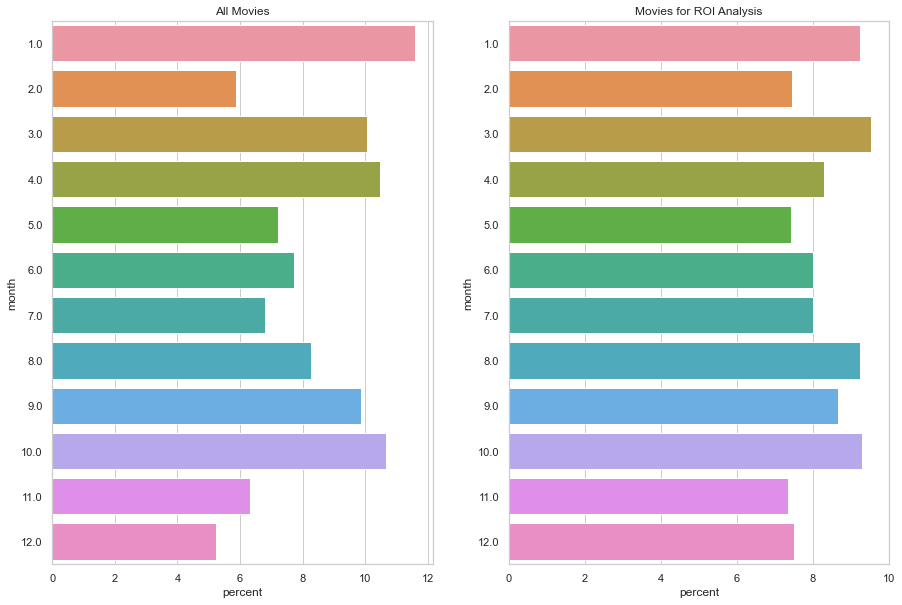

In [106]:
#compare dist months in side by side plots
fig, axs=plt.subplots(1,2,figsize=(15,10))
sns.barplot(data=m_count,y='month',x='percent',ax=axs[0])
axs[0].set_title('All Movies')
sns.barplot(data=mr_count,y='month',x='percent',ax=axs[1])
axs[1].set_title('Movies for ROI Analysis')

The main difference between the two distributions is that the ROI dataset is a bit flattened.  There are still peaks around Mar/Apr and Sep/Oct,but they are not as high and the percent of movies in other months does not dip as low. This could be a reflection of when lower budget movies tend to be released.

### Analyze ROI Dataset ###
Now that we've made some comparisons between the overall dataset and the subset we'll be using for ROI, we'll evaluate how ROI varies for genre, rating, and release month.

In [107]:
roi_df_exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3766 entries, 0 to 4018
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           3766 non-null   object 
 1   original_title   3766 non-null   object 
 2   start_year       3766 non-null   int64  
 3   runtime_minutes  3766 non-null   float64
 4   genres           3766 non-null   object 
 5   budget           3766 non-null   float64
 6   ww_gross         3766 non-null   float64
 7   mpaa_rating      3766 non-null   object 
 8   month            3766 non-null   float64
dtypes: float64(4), int64(1), object(4)
memory usage: 294.2+ KB


In [108]:
#create roi column
roi_df_exp['roi']=(roi_df_exp['ww_gross']/roi_df_exp['budget'])*100
roi_df_exp['roi'].describe()

count    3,766.00
mean       309.91
std        461.37
min          0.00
25%         58.14
50%        204.44
75%        389.29
max      5,917.07
Name: roi, dtype: float64

In [109]:
#groupby genres and calculate med ww_gross, then sort to get descending order
genre_med_roi=roi_df_exp.groupby('genres'
                        ).median()['roi'].sort_values(ascending=False)
g_med_roi_order=genre_med_roi.index

Text(0.5, 1.0, 'Median Worldwide Gross by Genre')

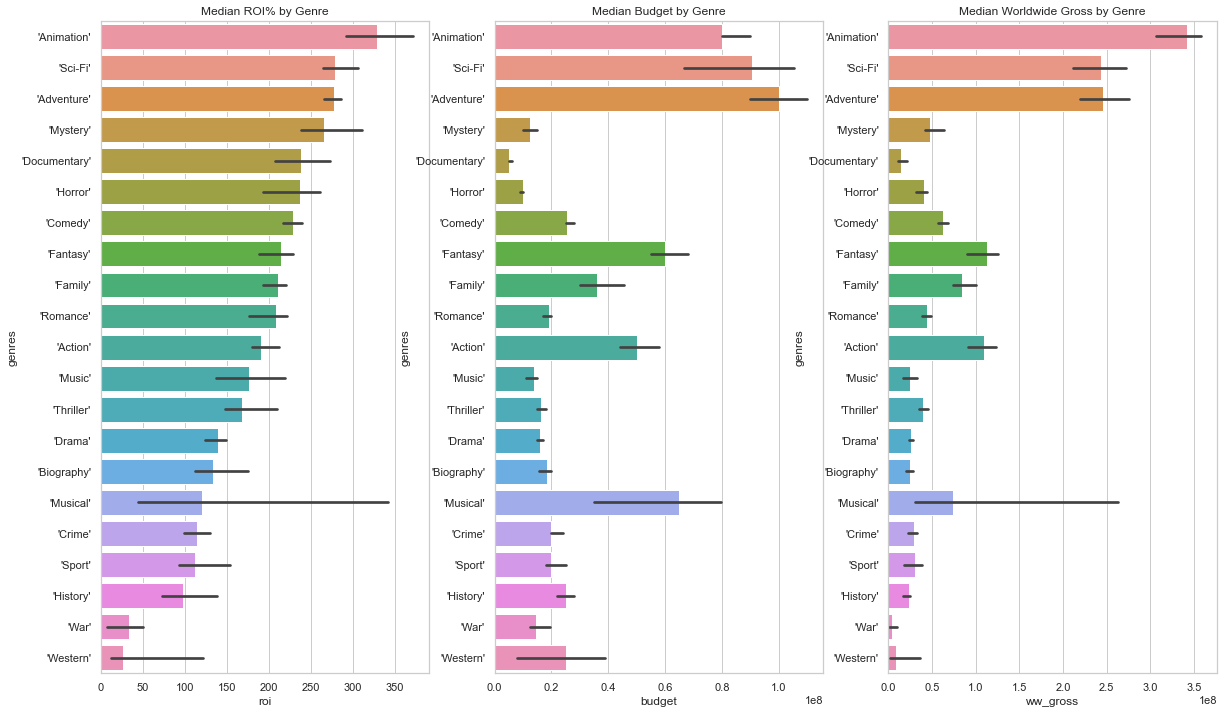

In [110]:
#plot the median roi for each genre
fig, axs=plt.subplots(1,3,figsize=(20,12))
sns.barplot(data=roi_df_exp,x='roi',y='genres',
            ci=68,order=g_med_roi_order,estimator=np.median,ax=axs[0])
axs[0].set_title('Median ROI% by Genre')
sns.barplot(data=roi_df_exp,x='budget',y='genres',
            ci=68,order=g_med_roi_order,estimator=np.median,ax=axs[1])
axs[1].set_title('Median Budget by Genre')
sns.barplot(data=roi_df_exp,x='ww_gross',y='genres',
           ci=68,order=g_med_roi_order,estimator=np.median,ax=axs[2])
axs[2].set_title('Median Worldwide Gross by Genre')

Animation, Sci-Fi, and Adventure are three of the top-5 highest grossing genres and are still the top genres in terms of ROI. However, Mystery, Documentary, Horror, and Comedy all beat out Fantasy in terms of ROI and Family and Romance are also ahead of Action.  This shows the impact that higher budgets in genres like Fantasy and Action have on the overall ROI.

Among genres with median budgets over $80,000,000, Animation, Sci-Fi, and Adventure return the most ROI. They also return the highest ROI overall (all greater than 250% median)

Among genres with median budgets under $40,000,000, Mystery, Documentary, Horror, Comedy, Family, and Romance genres all have a return over 200%. 

In [111]:
roi_df['roi']=(roi_df['ww_gross']/roi_df['budget'])*100

Text(0.5, 1.0, 'Median Budget by MPAA Rating')

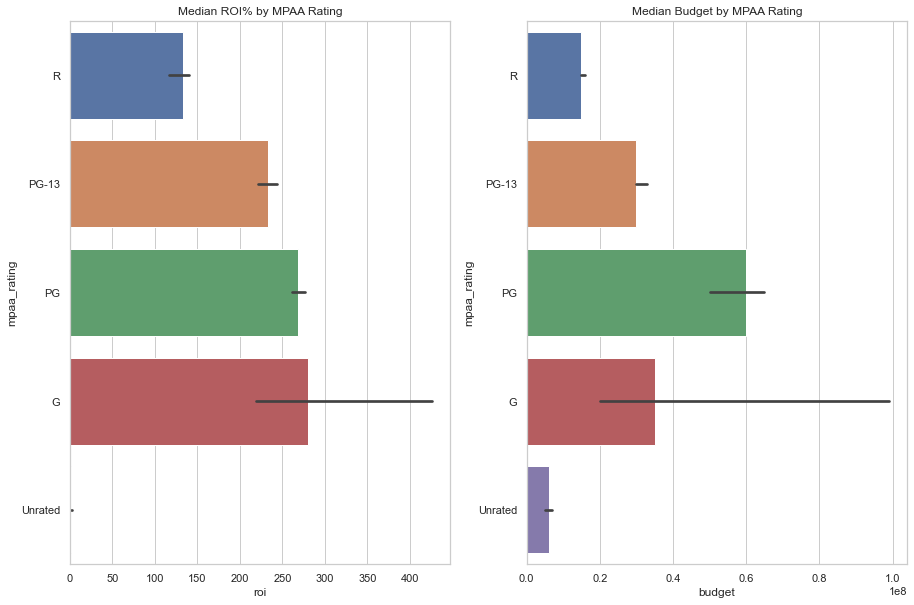

In [112]:
#examine the median ROI for each mpaa rating 

#use variable mpaa_ord for order

#plot the med roi for each mpaa rating
fig, axs=plt.subplots(1,2,figsize=(15,10))
sns.barplot(data=roi_df,x='roi',y='mpaa_rating',ci=68,
            order=mpaa_ord,estimator=np.median,ax=axs[0])
axs[0].set_title('Median ROI% by MPAA Rating')
sns.barplot(data=roi_df,x='budget',y='mpaa_rating',
            ci=68,order=mpaa_ord,estimator=np.median,ax=axs[1])
axs[1].set_title('Median Budget by MPAA Rating')

PG and PG-13 movies have the highest worldwide gross, but G movies show a higher ROI than either of those rating groups. Their budgets are lower on average than PG movies and lower than PG-13 movies relative to their average gross income.

In [113]:
#sort the month values in ascending order
roi_df=roi_df.sort_values('month')

In [114]:
#turn to string so they are plotted categorically
roi_df['month']=roi_df['month'].astype(str)

Text(0.5, 1.0, 'Median Budget by Release Month')

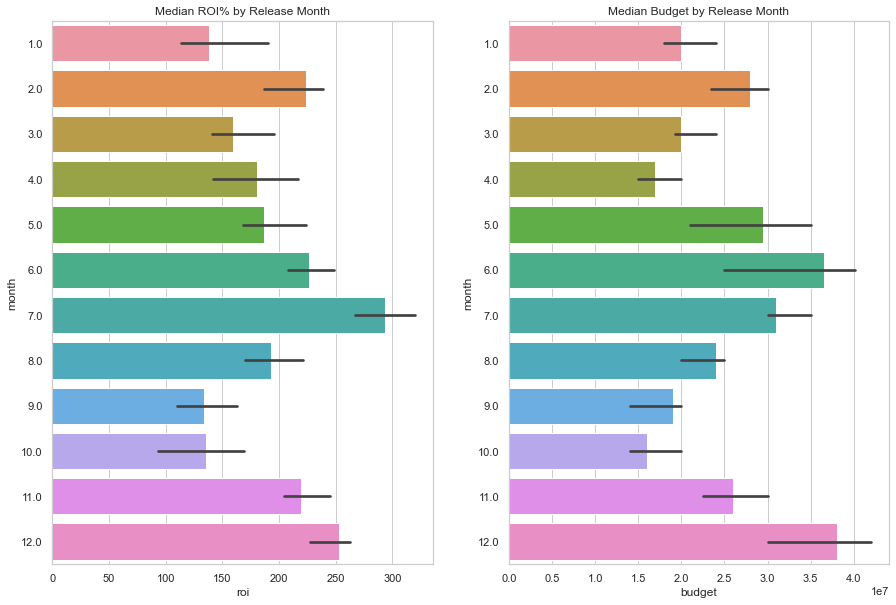

In [115]:
#examine median ROI by release month and compare with median budget side by side

#plot the median roi for each month
fig, axs=plt.subplots(1,2,figsize=(15,10))
sns.barplot(data=roi_df,x='roi',y='month',
            ci=68,estimator=np.median,ax=axs[0])
axs[0].set_title('Median ROI% by Release Month')
sns.barplot(data=roi_df,x='budget',y='month',
            ci=68,estimator=np.median,ax=axs[1])
axs[1].set_title('Median Budget by Release Month')

ROI peaks in both the summer months and holiday months like worldwide gross, but for ROI the highest month is July in the Summer vice December in the winter for Worldwide Gross. It is notable that there are more movies released during the dips in median ROI in Spring and Fall, but these months also have the lowest budgets on average.  High-budget 'Blockbusters' tend to be released in Summer/Winter.

### High Budget / High ROI Ratings and Release Month Analysis ###
Evaluate which ratings and release months are associated with the highest ROI for the top three high-budget/high-ROI genres: Animation, Sci-Fi, and Adventure.

In [116]:
#Strip quotations off the genres
roi_df_exp['genres']=roi_df_exp['genres'].str.strip("''")

In [117]:
#Separate animation, sci-fi, and adventure genres
hh_df=roi_df_exp[(roi_df_exp['genres']=='Animation') | 
                (roi_df_exp['genres']=='Sci-Fi') | 
                (roi_df_exp['genres']=='Adventure')]
hh_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 566 entries, 0 to 3932
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           566 non-null    object 
 1   original_title   566 non-null    object 
 2   start_year       566 non-null    int64  
 3   runtime_minutes  566 non-null    float64
 4   genres           566 non-null    object 
 5   budget           566 non-null    float64
 6   ww_gross         566 non-null    float64
 7   mpaa_rating      566 non-null    object 
 8   month            566 non-null    float64
 9   roi              566 non-null    float64
dtypes: float64(5), int64(1), object(4)
memory usage: 48.6+ KB


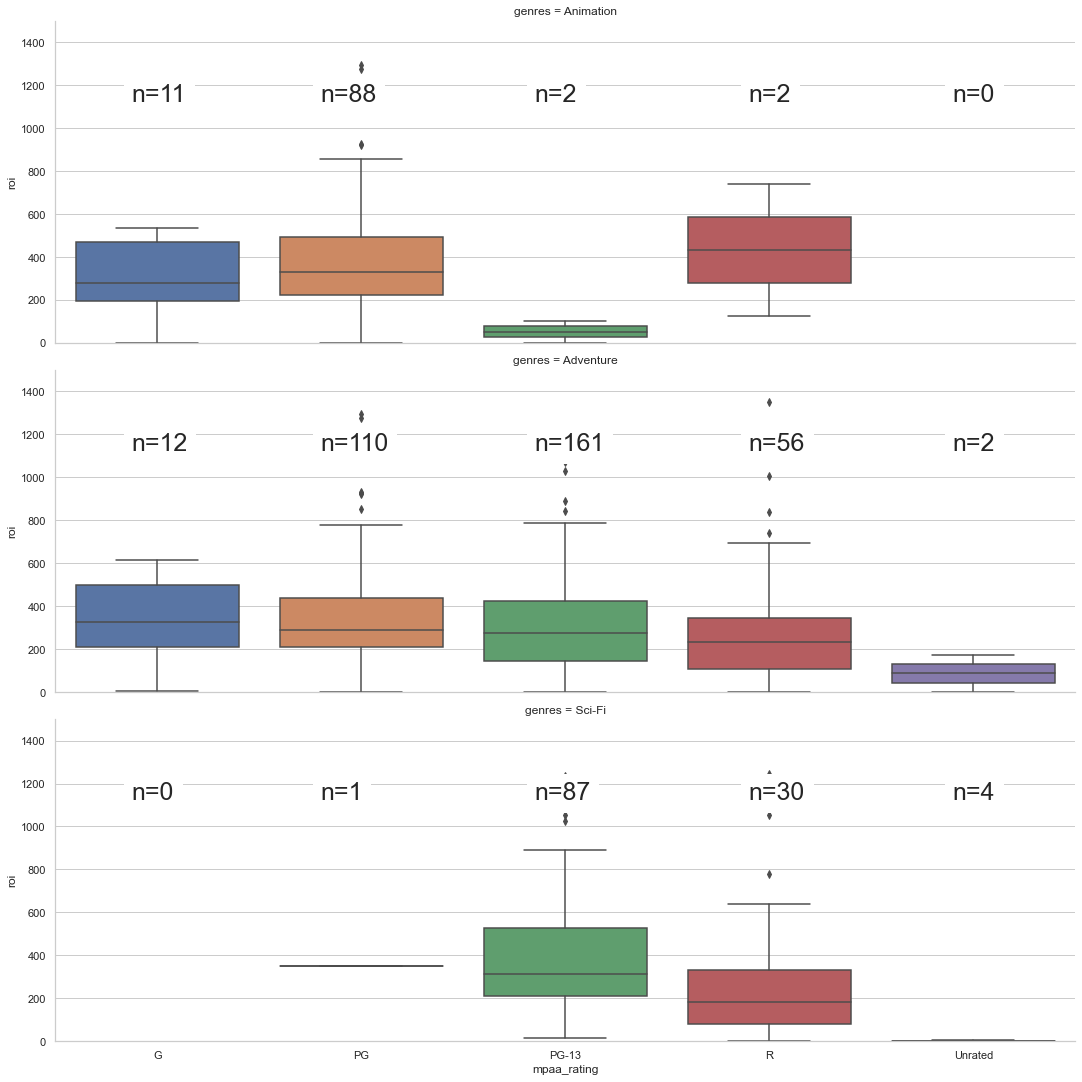

In [118]:
#Plot median ROI for each MPAA rating for each high-budget/high-roi genre

rg=sns.catplot(kind='box', row='genres', x='mpaa_rating',y='roi', 
              data=hh_df, estimator=np.median, aspect=3,
              order=['G','PG','PG-13','R','Unrated'])
rg.set(ylim=(0,1500))

#Calculate the number of observations per group and median to position labels
hh_counts=hh_df.groupby(['genres','mpaa_rating']).count()['roi']
hh_genres_list=['Animation','Adventure','Sci-Fi']
mpaa_list=['G','PG','PG-13','R','Unrated']
nobs_list=[]
for n in hh_genres_list:
    for m in mpaa_list:
        try:
            nobs_list.append(hh_counts[(n,m)])
        except:
            nobs_list.append(0)
c=0
for count, ax in enumerate(rg.axes.flat):
    ax.text(.075,.75,'n='+ str(nobs_list[c]),transform=ax.transAxes,
            fontsize=25,bbox=dict(boxstyle='square',facecolor='white'))
    c+=1
    ax.text(.26,.75,'n='+ str(nobs_list[c]),transform=ax.transAxes,
            fontsize=25,bbox=dict(boxstyle='square',facecolor='white'))
    c+=1
    ax.text(.47,.75,'n='+ str(nobs_list[c]),transform=ax.transAxes,
            fontsize=25,bbox=dict(boxstyle='square',facecolor='white'))
    c+=1
    ax.text(.68,.75,'n='+ str(nobs_list[c]),transform=ax.transAxes,
            fontsize=25,bbox=dict(boxstyle='square',facecolor='white'))
    c+=1
    ax.text(.88,.75,'n='+ str(nobs_list[c]),transform=ax.transAxes,
            fontsize=25,bbox=dict(boxstyle='square',facecolor='white'))
    c+=1

In [119]:
hh_df[(hh_df['genres']=='Animation')&(hh_df['mpaa_rating']=='R')]

,tconst,original_title,start_year,runtime_minutes,genres,budget,ww_gross,mpaa_rating,month,roi
1080,tt1700841,Sausage Party,2016,89.00,Animation,"19,000,000.00","140,705,322.00",R,8.00,740.55
3157,tt4853102,Batman: The Killing Joke,2016,76.00,Animation,"3,500,000.00","4,462,034.00",R,7.00,127.49


Evaluate best rating level for each genre

In [120]:
hh_df=hh_df.sort_values('month')
hh_df['month']=hh_df['month'].astype(float).astype(int).astype(str)
hh_df.head()

,tconst,original_title,start_year,runtime_minutes,genres,budget,ww_gross,mpaa_rating,month,roi
3031,tt4500922,Maze Runner: The Death Cure,2018,143.00,Sci-Fi,"62,000,000.00","288,175,335.00",PG-13,1,464.80
56,tt0490215,Silence,2016,161.00,Adventure,"46,000,000.00","23,834,809.00",R,1,51.81
823,tt1568338,Man on a Ledge,2012,102.00,Adventure,"42,000,000.00","47,636,031.00",PG-13,1,113.42
773,tt1542344,127 Hours,2010,94.00,Adventure,"18,000,000.00","60,738,797.00",R,1,337.44
49,tt0479997,Season of the Witch,2011,95.00,Adventure,"40,000,000.00","91,627,228.00",PG-13,1,229.07


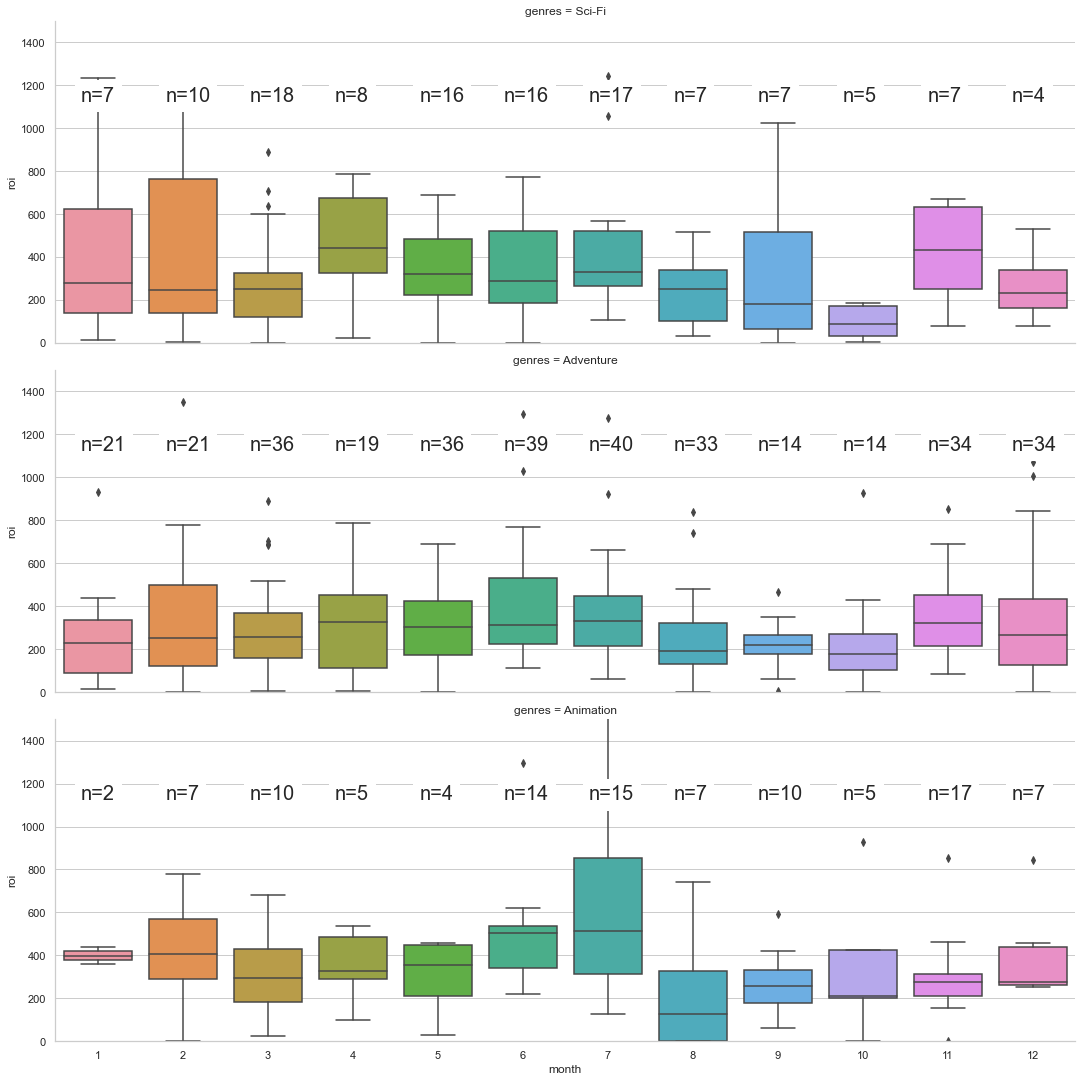

In [121]:
#Plot median ROI for each MPAA rating for each high-budget/high-roi genre
month_list=[str(x) for x in list(range(1,13))]
rg=sns.catplot(kind='box', row='genres', x='month',y='roi', 
              data=hh_df, estimator=np.median, aspect=3,order=month_list)
rg.set(ylim=(0,1500))

#Calculate the number of observations per group and median to position labels
hh_counts=hh_df.groupby(['genres','month']).count()['roi']
hh_genres_list=['Sci-Fi','Adventure','Animation']

nobs_list=[]
for n in hh_genres_list:
    for m in month_list:
        try:
            nobs_list.append(hh_counts[(n,m)])
        except:
            nobs_list.append(0)
c=0
for count, ax in enumerate(rg.axes.flat):
    x=.025
    for m in month_list:
        ax.text(x,.75,'n='+ str(nobs_list[c]),transform=ax.transAxes,
                fontsize=20,bbox=dict(boxstyle='square',facecolor='white'))
        c+=1
        x+=.083


## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***